In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score, r2_score
from sklearn.metrics import mean_squared_error as mse
from matplotlib import pyplot as plt
import seaborn as se
import h5py
from keras import backend as k
from keras.models import Model
from keras.layers import Dense, Input, Conv1D, Reshape, Flatten, Concatenate, Lambda, Activation, Layer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.losses import mean_squared_error, binary_crossentropy
from keras.initializers import Constant

Using TensorFlow backend.


In [2]:
TS = 318    #Data Tuple Size
GS = 131    #Game State Size
BAS = 77    #Batting State Size(7*11)
BOS = 110    #Bowling State Size(10*11)
CS_COL = 3    #CS column 0=>1st inning 1=>2nd inning
TAR_COL = 4    #Target column 
BAL_COL= 5    #Zeroth ball column number(balls are represented in one hot encoding)
RUN_COL = 126    #Run column number
WCK_COL = 127    #Wicket column number
BAT_COL = 131    #First column of batsmans data section
BOL_COL = 208    #First column of bowlers data section

In [3]:
h_train = h5py.File('train.h5', 'r')
h_validation = h5py.File('validation.h5', 'r')
h_test = h5py.File('test.h5', 'r')
print("Traning Games:", h_train['number'][0])
print("Validation Games:", h_validation['number'][0])
print("Testing Games:", h_test['number'][0])

Traning Games: 535
Validation Games: 115
Testing Games: 115


In [4]:
def make_shuffled_data(h5_file):
    data = None
    for game_number in range(1, h5_file['number'][0] + 1):
        print('File loading:', game_number)
        X_single = np.array(h5_file[str(game_number) + '_features'])
        y_single = np.array(h5_file[str(game_number) + '_target'])
        single = np.concatenate((X_single, y_single), axis=1)
        if data is None:
            data = single
        else:
            data = np.concatenate((data, single), axis=0)
    np.random.shuffle(data)
    X = data[:, :-3]
    y = data[:, -3:]
    return X, y[:, (0,2)]

In [5]:
UX_train, y_train = make_shuffled_data(h_train)
UX_validation, y_validation = make_shuffled_data(h_validation)
UX_test, y_test = make_shuffled_data(h_test)

File loading: 1
File loading: 2
File loading: 3
File loading: 4
File loading: 5
File loading: 6
File loading: 7
File loading: 8
File loading: 9
File loading: 10
File loading: 11
File loading: 12
File loading: 13
File loading: 14
File loading: 15
File loading: 16
File loading: 17
File loading: 18
File loading: 19
File loading: 20
File loading: 21
File loading: 22
File loading: 23
File loading: 24
File loading: 25
File loading: 26
File loading: 27
File loading: 28
File loading: 29
File loading: 30
File loading: 31
File loading: 32
File loading: 33
File loading: 34
File loading: 35
File loading: 36
File loading: 37
File loading: 38
File loading: 39
File loading: 40
File loading: 41
File loading: 42
File loading: 43
File loading: 44
File loading: 45
File loading: 46
File loading: 47
File loading: 48
File loading: 49
File loading: 50
File loading: 51
File loading: 52
File loading: 53
File loading: 54
File loading: 55
File loading: 56
File loading: 57
File loading: 58
File loading: 59
File l

File loading: 464
File loading: 465
File loading: 466
File loading: 467
File loading: 468
File loading: 469
File loading: 470
File loading: 471
File loading: 472
File loading: 473
File loading: 474
File loading: 475
File loading: 476
File loading: 477
File loading: 478
File loading: 479
File loading: 480
File loading: 481
File loading: 482
File loading: 483
File loading: 484
File loading: 485
File loading: 486
File loading: 487
File loading: 488
File loading: 489
File loading: 490
File loading: 491
File loading: 492
File loading: 493
File loading: 494
File loading: 495
File loading: 496
File loading: 497
File loading: 498
File loading: 499
File loading: 500
File loading: 501
File loading: 502
File loading: 503
File loading: 504
File loading: 505
File loading: 506
File loading: 507
File loading: 508
File loading: 509
File loading: 510
File loading: 511
File loading: 512
File loading: 513
File loading: 514
File loading: 515
File loading: 516
File loading: 517
File loading: 518
File loadi

In [6]:
print(UX_train.shape, y_train.shape)
print(UX_validation.shape, y_validation.shape)
print(UX_test.shape, y_test.shape)

(127785, 318) (127785, 2)
(27522, 318) (27522, 2)
(27503, 318) (27503, 2)


In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(UX_train)
X_validation = scaler.transform(UX_validation)
X_test = scaler.transform(UX_test)

In [8]:
def mse_loss(y_true, y_pred):
    return mean_squared_error(y_true[:, 0], y_pred[:, 0])

def bce_loss(y_true,y_pred):
    return binary_crossentropy(y_true[:, 1], y_pred[:, 1])

In [9]:
class loss_layer(Layer): 
    
    def build(self, input_shape = None):
        self.log_var1 = self.add_weight(name = 'log_var1', shape = (1,), initializer = Constant(0.), trainable = True)
        self.log_var2 = self.add_weight(name = 'log_var2', shape = (1,), initializer = Constant(0.), trainable = True)
        super().build(input_shape)

    def loss(self, y_true, y_pred):
        loss = 0.5*k.exp(-2*self.log_var1[0]) * mse_loss(y_true, y_pred) + k.exp(-2*self.log_var2[0]) * bce_loss(y_true, y_pred) + self.log_var1[0] + self.log_var2[0]
        return k.mean(loss)

    def call(self, inputs):
        loss = self.loss(inputs[0], inputs[1])
        self.add_loss(loss, inputs = inputs)
        return inputs[1]

In [10]:
def gen_model(learning_rate = 0.001):
    
    X = Input(shape = (GS + BAS + BOS,))
    y_true = Input(shape = (2,))

    game_state = Lambda(lambda x : x[:, 0:GS])(X)
    batting_state = Lambda(lambda x : x[:, GS:GS+BAS])(X)
    bowling_state = Lambda(lambda x : x[:, GS+BAS:])(X)

    #Processing game_state
    game = Dense(8, activation='relu')(game_state)
    game = Dense(4, activation='relu')(game)

    #Processing batting_state
    batting = Reshape((11,7))(batting_state)
    batting = Conv1D(4, 1, strides = 1, padding = 'valid', activation = 'relu', name = 'first_batting_conv1d')(batting)
    batting = Conv1D(1, 1, strides = 1, padding = 'valid', activation = 'relu', name = 'second_batting_conv1d')(batting)
    batting = Flatten()(batting)
    batting = Dense(2, activation = 'relu')(batting)

    #Processing bowling_state
    bowling = Reshape((11,10))(bowling_state)
    bowling = Conv1D(4, 1, strides = 1, padding = 'valid', activation = 'relu', name = 'first_bowling_conv1d')(bowling)
    bowling = Conv1D(1, 1, strides = 1, padding = 'valid', activation = 'relu', name = 'second_bowling_conv1d')(bowling)
    bowling = Flatten()(bowling)
    bowling = Dense(2, activation = 'relu')(bowling)

    #Concatenate features
    com = Concatenate(axis = 1)([game, batting, bowling])
    com = Dense(8, activation = 'relu')(com)
    com = Dense(2, activation = None)(com)

    #Process Output
    runs = Lambda(lambda x : x[:, 0])(com)
    runs = Activation('relu')(runs)
    runs = Reshape((1,))(runs)

    probs = Lambda(lambda x : x[:, 1])(com)
    probs = Activation('sigmoid')(probs)
    probs = Reshape((1,))(probs)

    y_pred = Concatenate(axis = 1)([runs, probs])

    mse = mse_loss(y_true, y_pred)
    bce = bce_loss(y_true, y_pred)
    
    out = loss_layer()([y_true, y_pred])

    #Define Model
    model = Model(inputs = [X, y_true], outputs = out)

    model.compile(optimizer = Adam(learning_rate))
    model.metrics_tensors.append(mse)
    model.metrics_names.append("MSE")
    model.metrics_tensors.append(bce)
    model.metrics_names.append("BCE")
    
    return model

In [11]:
class gen_pred_model():
    def __init__(self, model):
        self.model = model
        
    def predict(self, X):
        dummy_y = np.random.rand(X.shape[0], 2)
        return self.model.predict([X, dummy_y])

In [12]:
trainable_model = gen_model()
model = gen_pred_model(trainable_model)

W1221 09:59:20.460231 11548 deprecation_wrapper.py:119] From C:\Users\HP\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1221 09:59:20.507826 11548 deprecation_wrapper.py:119] From C:\Users\HP\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1221 09:59:20.541939 11548 deprecation_wrapper.py:119] From C:\Users\HP\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1221 09:59:20.916911 11548 deprecation_wrapper.py:119] From C:\Users\HP\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W1221 09:59:20.947211 11548 deprecation.py:323] From C:\Users\HP\Anaconda3\lib\site-packages\tensorflow\

In [13]:
#trainable_model.load_weights('best_model.h5')

In [14]:
trainable_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 318)          0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 77)           0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 110)          0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 11, 7)        0           lambda_2[0][0]                   
__________________________________________________________________________________________________
reshape_2 

In [15]:
def lr_scheduler(epoch, lr):
    if epoch % 20 == 0 and epoch:
        return lr/2
    return lr

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 15, verbose = 1, mode = 'min')
model_saver = ModelCheckpoint('best_model.h5', save_best_only = True, verbose = 1, monitor = 'val_loss', mode = 'min')
callbacks = [LearningRateScheduler(lr_scheduler, verbose=1), early_stopping, model_saver]

In [16]:
trainable_model.fit([X_train, y_train], epochs = 60, batch_size = 64, callbacks = callbacks, validation_data = ([X_validation, y_validation], None))

W1221 09:59:21.921567 11548 deprecation_wrapper.py:119] From C:\Users\HP\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 127785 samples, validate on 27522 samples
Epoch 1/60

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
127785/127785 [==============================] - 11s 89us/step - loss: 1330.6477 - MSE: 3496.8565 - BCE: 0.7498 - val_loss: 217.1990 - val_MSE: 872.3444 - val_BCE: 0.7093

Epoch 00001: val_loss improved from inf to 217.19901, saving model to best_model.h5
Epoch 2/60

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
127785/127785 [==============================] - 12s 91us/step - loss: 120.9888 - MSE: 581.8053 - BCE: 0.6982 - val_loss: 93.1887 - val_MSE: 569.4619 - val_BCE: 0.6929

Epoch 00002: val_loss improved from 217.19901 to 93.18867, saving model to best_model.h5
Epoch 3/60

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
127785/127785 [==============================] - 11s 87us/step - loss: 56.2338 - MSE: 430.4051 - BCE: 0.6920 - val_loss: 41.7024 - val_MSE: 425.6295 -

127785/127785 [==============================] - 11s 82us/step - loss: 3.9264 - MSE: 321.1246 - BCE: 0.5421 - val_loss: 3.9815 - val_MSE: 355.4678 - val_BCE: 0.5443

Epoch 00025: val_loss improved from 3.98516 to 3.98148, saving model to best_model.h5
Epoch 26/60

Epoch 00026: LearningRateScheduler setting learning rate to 0.0005000000237487257.
127785/127785 [==============================] - 11s 86us/step - loss: 3.9253 - MSE: 320.6703 - BCE: 0.5417 - val_loss: 3.9861 - val_MSE: 359.0259 - val_BCE: 0.5426

Epoch 00026: val_loss did not improve from 3.98148
Epoch 27/60

Epoch 00027: LearningRateScheduler setting learning rate to 0.0005000000237487257.
127785/127785 [==============================] - 11s 84us/step - loss: 3.9245 - MSE: 320.4013 - BCE: 0.5413 - val_loss: 3.9774 - val_MSE: 353.6365 - val_BCE: 0.5408

Epoch 00027: val_loss improved from 3.98148 to 3.97736, saving model to best_model.h5
Epoch 28/60

Epoch 00028: LearningRateScheduler setting learning rate to 0.000500000023

127785/127785 [==============================] - 11s 85us/step - loss: 3.9102 - MSE: 315.1914 - BCE: 0.5347 - val_loss: 3.9611 - val_MSE: 348.6060 - val_BCE: 0.5321

Epoch 00050: val_loss did not improve from 3.95755
Epoch 51/60

Epoch 00051: LearningRateScheduler setting learning rate to 0.0002500000118743628.
127785/127785 [==============================] - 11s 83us/step - loss: 3.9103 - MSE: 315.1179 - BCE: 0.5349 - val_loss: 3.9611 - val_MSE: 348.2402 - val_BCE: 0.5331

Epoch 00051: val_loss did not improve from 3.95755
Epoch 52/60

Epoch 00052: LearningRateScheduler setting learning rate to 0.0002500000118743628.
127785/127785 [==============================] - 11s 82us/step - loss: 3.9097 - MSE: 314.9965 - BCE: 0.5346 - val_loss: 3.9570 - val_MSE: 348.0018 - val_BCE: 0.5290

Epoch 00052: val_loss improved from 3.95755 to 3.95698, saving model to best_model.h5
Epoch 53/60

Epoch 00053: LearningRateScheduler setting learning rate to 0.0002500000118743628.
127785/127785 [===========

In [17]:
trainable_model.save('final_model.h5')

In [18]:
def print_stats(y_true, y_pred):
    runs_preds = y_pred[:, 0]
    runs_true = y_true[:, 0]
    probs_preds = y_pred[:, 1]
    probs_true = y_true[:, 1]
    #Regression Analysis------------------------------------------------------------------------
    print('Runs predicted evaluation...')
    print('True: ', runs_true[0:5], '...')
    print('Pred: ', np.round(runs_preds[0:5], 2), '...')
    runs_r2 = r2_score(runs_true, runs_preds)
    runs_mse = mse(runs_true, runs_preds)
    print('R2 Score of predicting runs: ', runs_r2)
    print('MSE Score of predicting runs:', runs_mse)
    #Classification Analysis---------------------------------------------------------------------
    print('Probs predicted comparision...')
    print('True: ', probs_true[0:5], '...')
    print('Pred: ', np.round(probs_preds[0:5],2), '...')
    print('Confusion matrix of win or lose prediction:')
    con_mat = confusion_matrix(probs_true, probs_preds>0.5)
    df = pd.DataFrame(con_mat, index = ['Loss','Win'], columns = ['Loss','Win'])
    se.heatmap(df, annot=True)
    plt.show()
    accuracy = (con_mat[0][0] + con_mat[1][1])/(np.sum(con_mat))
    print('Accuracy: ', accuracy)
    fp, tp, _ = roc_curve(probs_true, probs_preds)
    plt.plot(fp, tp)
    plt.title('Receiver operating characteristic (ROC) for win/loss prediction:')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.show()
    area = roc_auc_score(probs_true, probs_preds)
    print('Area under ROC-Curve for win/loss prediction:', area)
    precision, recall, _ = precision_recall_curve(probs_true, probs_preds)
    plt.step(recall, precision, color='b', alpha=0.2,where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve for win/loss prediction:')
    plt.show()

In [19]:
def print_stats_with_innings_and_balls(X, y_true, y_pred, lball, uball):
    One_Hot_balls = X[:, BAL_COL:BAL_COL+121]
    balls = np.argmax(One_Hot_balls, axis = 1)
    bool_var = ((balls >= lball) * (balls <= uball)).astype('bool')
    first_inning = (X[:, CS_COL] == 0)*bool_var
    second_inning= (X[:, CS_COL] == 1)*bool_var
    #Both Innings
    print('--------------------------Stats of both innings combined:------------------------------')
    print_stats(y_true, y_pred)
    #First Innings
    if any(first_inning):
        print('--------------------------Stats of first innings:------------------------------')
        f_y_pred = y_pred[first_inning]
        f_y_true = y_true[first_inning]
        print_stats(f_y_true, f_y_pred)
    #Second_Innings
    if any(second_inning):
        print('--------------------------Stats of second innings:------------------------------')
        s_y_pred = y_pred[second_inning]
        s_y_true = y_true[second_inning]
        print_stats(s_y_true, s_y_pred)

--------------------------Stats of both innings combined:------------------------------
Runs predicted evaluation...
True:  [142. 197. 180. 172.  90.] ...
Pred:  [158.39 185.46 177.09 173.13  90.82] ...
R2 Score of predicting runs:  0.6342159104685801
MSE Score of predicting runs: 313.66682292385644
Probs predicted comparision...
True:  [1. 0. 0. 1. 1.] ...
Pred:  [0.6  0.65 0.46 0.65 0.96] ...
Confusion matrix of win or lose prediction:


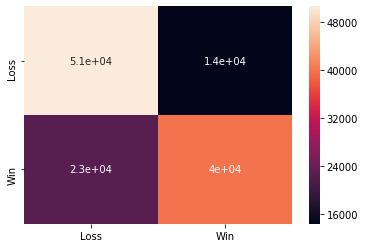

Accuracy:  0.7093164299409164


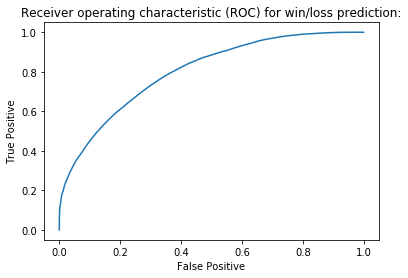

Area under ROC-Curve for win/loss prediction: 0.8000133087870225


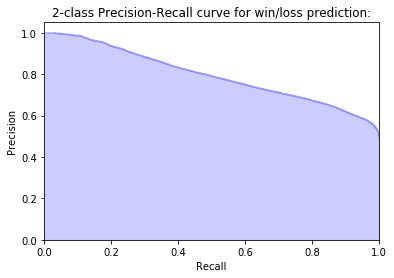

--------------------------Stats of first innings:------------------------------
Runs predicted evaluation...
True:  [142. 197. 180. 172. 126.] ...
Pred:  [158.39 185.46 177.09 173.13 152.58] ...
R2 Score of predicting runs:  0.5547783367626311
MSE Score of predicting runs: 382.01577932444377
Probs predicted comparision...
True:  [1. 0. 0. 1. 0.] ...
Pred:  [0.6  0.65 0.46 0.65 0.35] ...
Confusion matrix of win or lose prediction:


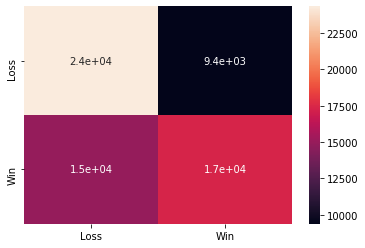

Accuracy:  0.631202774118324


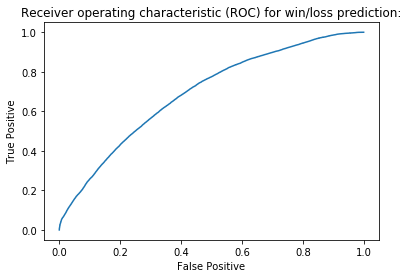

Area under ROC-Curve for win/loss prediction: 0.69241707234512


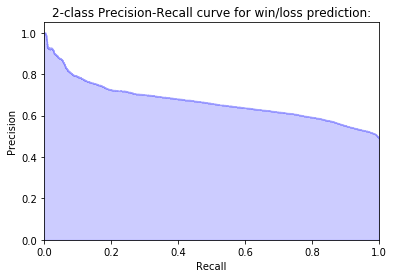

--------------------------Stats of second innings:------------------------------
Runs predicted evaluation...
True:  [ 90. 143. 142. 119. 146.] ...
Pred:  [ 90.82 136.34 156.53 110.17 155.13] ...
R2 Score of predicting runs:  0.6870741623386423
MSE Score of predicting runs: 240.56578428591402
Probs predicted comparision...
True:  [1. 0. 0. 1. 0.] ...
Pred:  [0.96 0.01 0.49 0.81 0.16] ...
Confusion matrix of win or lose prediction:


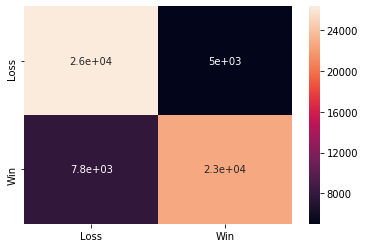

Accuracy:  0.7928610760211188


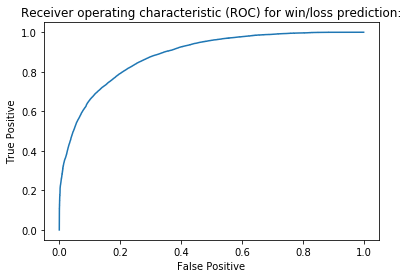

Area under ROC-Curve for win/loss prediction: 0.8843468117118158


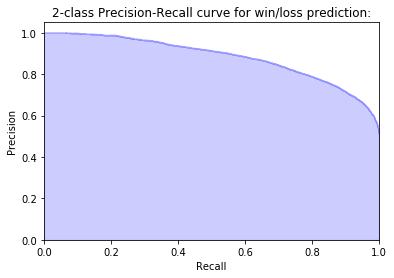

In [20]:
y_pred = model.predict(X_train)
print_stats_with_innings_and_balls(X_train, y_train, y_pred, 0, 120)

--------------------------Stats of both innings combined:------------------------------
Runs predicted evaluation...
True:  [ 60. 162. 167. 230. 146.] ...
Pred:  [116.64 163.86 163.2  195.84 142.18] ...
R2 Score of predicting runs:  0.6720409361697628
MSE Score of predicting runs: 347.0020833073244
Probs predicted comparision...
True:  [0. 1. 0. 1. 1.] ...
Pred:  [0.74 0.38 0.1  0.11 0.81] ...
Confusion matrix of win or lose prediction:


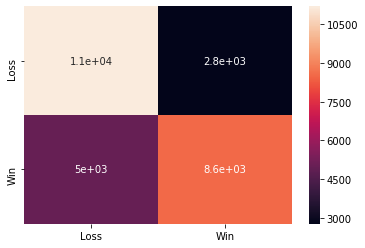

Accuracy:  0.7181164159581426


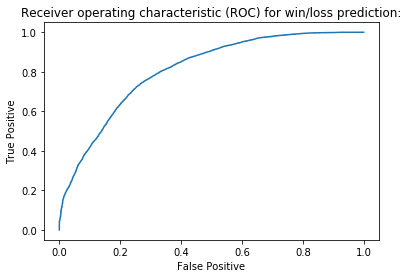

Area under ROC-Curve for win/loss prediction: 0.8087683320156742


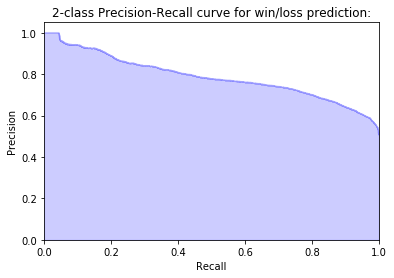

--------------------------Stats of first innings:------------------------------
Runs predicted evaluation...
True:  [162. 135. 183. 150. 263.] ...
Pred:  [163.86 136.73 173.86 155.9  227.36] ...
R2 Score of predicting runs:  0.5925828118425627
MSE Score of predicting runs: 422.0015395142952
Probs predicted comparision...
True:  [1. 1. 1. 1. 1.] ...
Pred:  [0.38 0.23 0.44 0.49 0.92] ...
Confusion matrix of win or lose prediction:


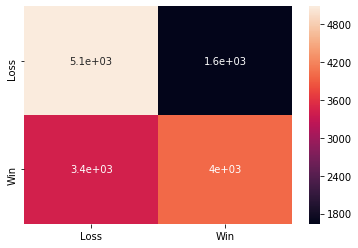

Accuracy:  0.6417973717676981


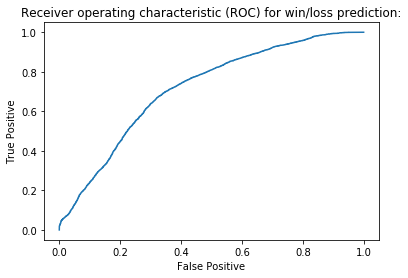

Area under ROC-Curve for win/loss prediction: 0.7145994334746713


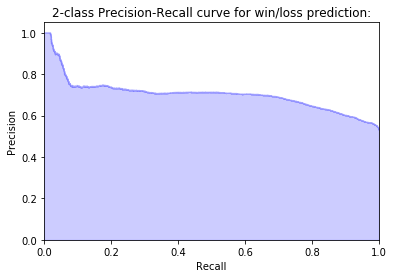

--------------------------Stats of second innings:------------------------------
Runs predicted evaluation...
True:  [ 60. 167. 230. 146. 201.] ...
Pred:  [116.64 163.2  195.84 142.18 210.19] ...
R2 Score of predicting runs:  0.724794889139411
MSE Score of predicting runs: 267.59287451367805
Probs predicted comparision...
True:  [0. 0. 1. 1. 0.] ...
Pred:  [0.74 0.1  0.11 0.81 0.33] ...
Confusion matrix of win or lose prediction:


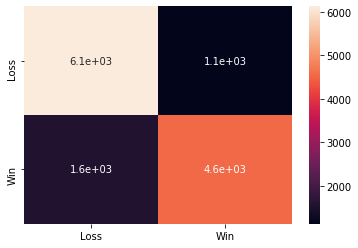

Accuracy:  0.7989228007181328


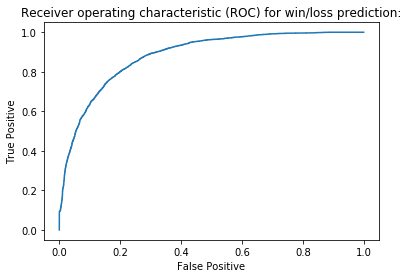

Area under ROC-Curve for win/loss prediction: 0.8830026590166421


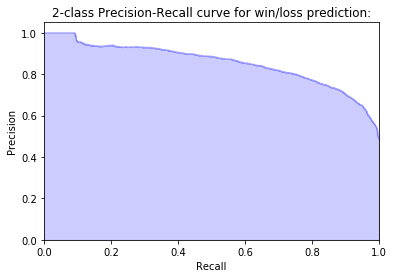

In [21]:
y_pred = model.predict(X_validation)
print_stats_with_innings_and_balls(X_validation, y_validation, y_pred, 0, 120)

--------------------------Stats of both innings combined:------------------------------
Runs predicted evaluation...
True:  [144. 120. 129. 108. 163.] ...
Pred:  [150.41 114.48 142.45 133.56 151.96] ...
R2 Score of predicting runs:  0.6273966971940013
MSE Score of predicting runs: 344.0286972775574
Probs predicted comparision...
True:  [0. 1. 1. 0. 1.] ...
Pred:  [0.31 0.55 0.21 0.01 0.38] ...
Confusion matrix of win or lose prediction:


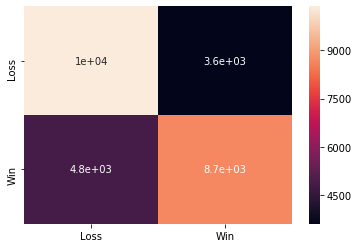

Accuracy:  0.693451623459259


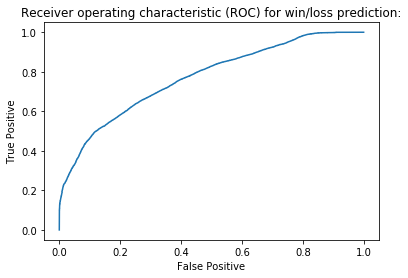

Area under ROC-Curve for win/loss prediction: 0.770237194618975


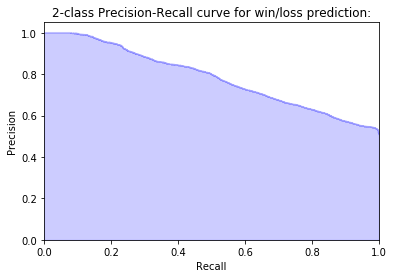

--------------------------Stats of first innings:------------------------------
Runs predicted evaluation...
True:  [129. 172. 153. 141. 205.] ...
Pred:  [142.45 160.32 148.55 138.69 214.05] ...
R2 Score of predicting runs:  0.5525168532063459
MSE Score of predicting runs: 405.1245103026092
Probs predicted comparision...
True:  [1. 0. 0. 0. 1.] ...
Pred:  [0.21 0.42 0.55 0.47 0.83] ...
Confusion matrix of win or lose prediction:


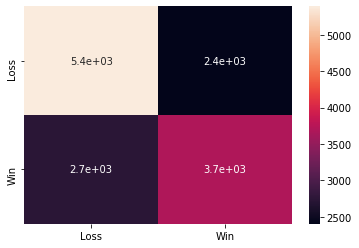

Accuracy:  0.6386389201349831


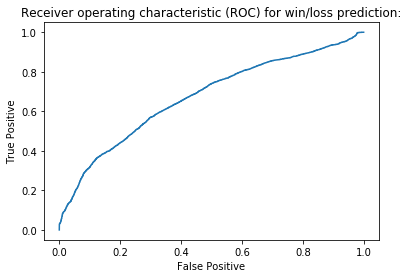

Area under ROC-Curve for win/loss prediction: 0.673046890962283


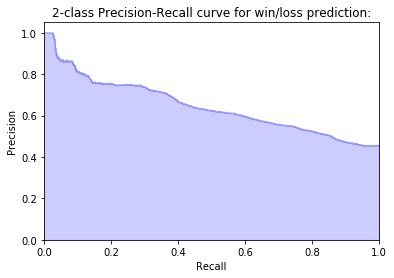

--------------------------Stats of second innings:------------------------------
Runs predicted evaluation...
True:  [144. 120. 108. 163. 161.] ...
Pred:  [150.41 114.48 133.56 151.96 176.86] ...
R2 Score of predicting runs:  0.6805928257254257
MSE Score of predicting runs: 278.58500087961045
Probs predicted comparision...
True:  [0. 1. 0. 1. 0.] ...
Pred:  [0.31 0.55 0.01 0.38 0.08] ...
Confusion matrix of win or lose prediction:


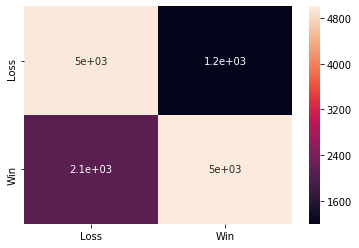

Accuracy:  0.7521650726711349


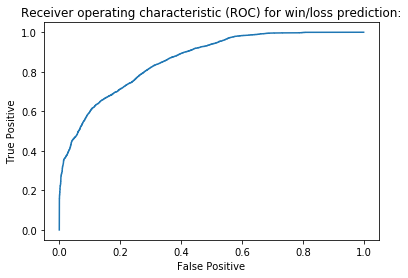

Area under ROC-Curve for win/loss prediction: 0.8604475378500367


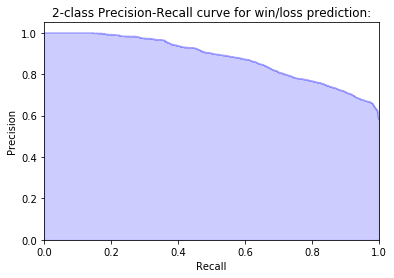

In [22]:
y_pred = model.predict(X_test)
print_stats_with_innings_and_balls(X_test, y_test, y_pred, 0, 120)

In [23]:
def cal_avg_run_and_wicket(h_file):
    total_games = h_file['number'][0]
    run_sum = 0
    wicket_sum = 0
    for i in range(1, total_games + 1):
        X_var = np.array(h_train[str(i) + '_features'])
        first_balls = X_var[X_var[:, BAL_COL + 1] == 1]
        first_inning_first_balls = first_balls[first_balls[:, CS_COL] == 0][-1,:]
        second_inning_first_balls = first_balls[first_balls[:,CS_COL] == 1][-1,:]
        run_sum = run_sum + first_inning_first_balls[RUN_COL] + second_inning_first_balls[RUN_COL]
        wicket_sum = wicket_sum + first_inning_first_balls[WCK_COL] + second_inning_first_balls[WCK_COL]
    return run_sum/total_games,wicket_sum/total_games

In [24]:
cal_avg_run_and_wicket(h_train)

(1.7850467289719627, 0.056074766355140186)

In [25]:
def set_target(ball, targets):
    balls = np.tile(ball, (targets.shape[0], 1))
    for i in range(targets.shape[0]):
        balls[i, TAR_COL] = targets[i]
    return balls

In [26]:
#Higest inning bowler
def make_first_ball(ball):
    ball[0, BAL_COL:GS] = 0
    for i in range(BAT_COL, BAT_COL + BAS, 7):
        ball[0, i] = 0
        ball[0, i+1] = 0
        ball[0, i+2] = 0
        ball[0, i+3] = 0
    for i in range(BAT_COL+BAS, TS, 10):
        ball[0, i] = 0
        ball[0, i+1] = 0
        ball[0, i+2] = 0
        ball[0, i+3] = 0
        ball[0, i+4] = 0
        ball[0, i+5] = 0
    run = 1.7850
    ball[0, BAL_COL + 1] = 1
    ball[0, RUN_COL] = run
    ball[0, BAT_COL] = 1
    ball[0, BAT_COL + 1] = run
    ball[0, BAT_COL + 2] = run
    ball[0, BOL_COL] = 1
    ball[0, BOL_COL + 1] = run
    ball[0, BOL_COL + 3] = run
    ball[0, BOL_COL + 4] = 1e8
    ball[0, BOL_COL + 5] = 1e8
    return ball

In [27]:
#to do :- Second innings stats discripency
def print_stat_using_model_pipelineing(h5_file, lball, uball):
    X = None
    outputs = None
    y = None
    for i in range(1, h5_file['number'][0] + 1):
        X_var = np.array(h5_file[str(i) + '_features'])
        y_var = np.array(h5_file[str(i) + '_target'])[:, (0,2)]
        first_inning = (X_var[:, CS_COL]==0)
        second_inning = (X_var[:, CS_COL]==1)
        f_X_var = X_var[first_inning]
        f_y_var = y_var[first_inning]
        s_X_var = X_var[second_inning]
        s_y_var = y_var[second_inning]
        #Finding zero ball snapshot of second inning
        S_first_ball = X_var[X_var[:, CS_COL]==1][0,:]
        S_first_ball = np.expand_dims(S_first_ball, axis=0)
        S_first_ball = make_first_ball(S_first_ball)
        f_X_var = scaler.transform(f_X_var)
        targets = model.predict(f_X_var)[:, 0]
        first_balls_with_target = set_target(S_first_ball, targets)
        first_balls_with_target = scaler.transform(first_balls_with_target)
        wl_pred = 1 - model.predict(first_balls_with_target)[:, 1]
        first_inning_output = np.stack((targets, wl_pred), axis=1)
        s_X_var = scaler.transform(s_X_var)
        second_inning_output = model.predict(s_X_var)   
        output_single = np.concatenate((first_inning_output, second_inning_output), axis=0)
        X_single = np.concatenate((f_X_var, s_X_var), axis=0)
        y_single = np.concatenate((f_y_var, s_y_var), axis=0)
        if X is None:
            X = X_single
            y = y_single
            output = output_single
        else:
            X = np.concatenate((X, X_single), axis=0)
            y = np.concatenate((y, y_single), axis=0)
            output = np.concatenate((output, output_single), axis=0)
    print_stats_with_innings_and_balls(X, y, output, lball, uball)

--------------------------Stats of both innings combined:------------------------------
Runs predicted evaluation...
True:  [147. 147. 147. 147. 147.] ...
Pred:  [158.32 158.02 145.31 146.3  147.8 ] ...
R2 Score of predicting runs:  0.672040936521097
MSE Score of predicting runs: 347.00208293558995
Probs predicted comparision...
True:  [0. 0. 0. 0. 0.] ...
Pred:  [0.53 0.52 0.35 0.37 0.39] ...
Confusion matrix of win or lose prediction:


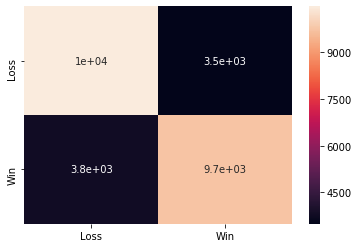

Accuracy:  0.7349756558389652


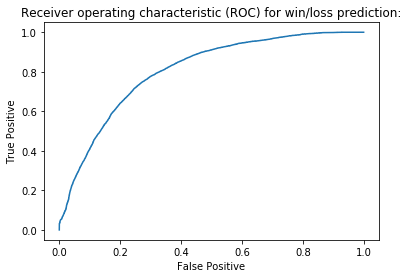

Area under ROC-Curve for win/loss prediction: 0.8047425844761285


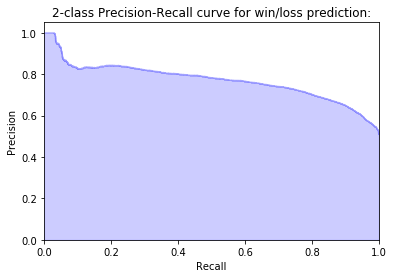

--------------------------Stats of first innings:------------------------------
Runs predicted evaluation...
True:  [147. 147. 147. 147. 147.] ...
Pred:  [158.32 158.02 145.31 146.3  147.8 ] ...
R2 Score of predicting runs:  0.5925828118116657
MSE Score of predicting runs: 422.0015395462981
Probs predicted comparision...
True:  [0. 0. 0. 0. 0.] ...
Pred:  [0.53 0.52 0.35 0.37 0.39] ...
Confusion matrix of win or lose prediction:


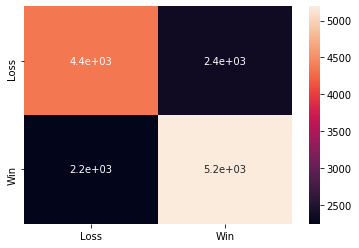

Accuracy:  0.6745796241345203


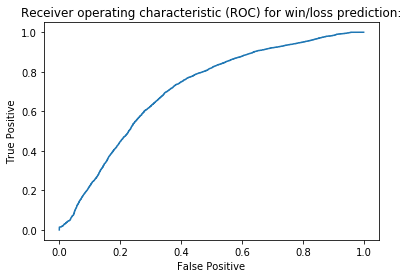

Area under ROC-Curve for win/loss prediction: 0.7111248697028577


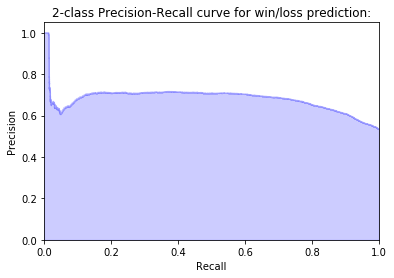

--------------------------Stats of second innings:------------------------------
Runs predicted evaluation...
True:  [148. 148. 148. 148. 148.] ...
Pred:  [138.02 138.41 138.23 137.62 137.12] ...
R2 Score of predicting runs:  0.7247948899613565
MSE Score of predicting runs: 267.5928737144677
Probs predicted comparision...
True:  [1. 1. 1. 1. 1.] ...
Pred:  [0.59 0.6  0.58 0.59 0.59] ...
Confusion matrix of win or lose prediction:


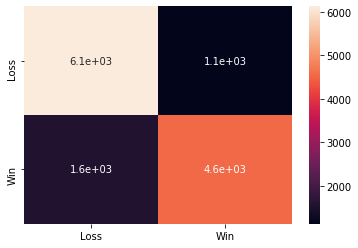

Accuracy:  0.7989228007181328


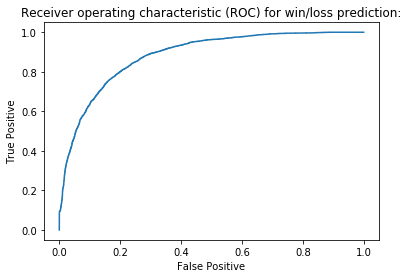

Area under ROC-Curve for win/loss prediction: 0.8830026815623364


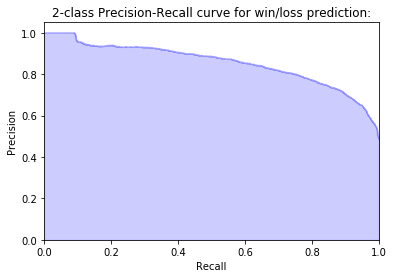

In [28]:
print_stat_using_model_pipelineing(h_validation, 0, 120)

In [29]:
def print_stat_before_game_start(h5_file):
    total_games = h5_file['number'][0]
    pred = None
    true = None
    for i in range(1, total_games + 1):
        X_var = np.array(h5_file[str(i) + '_features'])
        y_var = np.array(h5_file[str(i) + '_target'])[:, (0,2)]

        first_inning_first_ball = X_var[0, :]
        second_inning_first_ball = X_var[(X_var[:, CS_COL] == 1)][0, :]

        first_inning_first_ball = np.expand_dims(first_inning_first_ball, axis=0)
        second_inning_first_ball = np.expand_dims(second_inning_first_ball, axis=0)

        first_inning_first_ball = make_first_ball(first_inning_first_ball)
        second_inning_first_ball = make_first_ball(second_inning_first_ball)

        first_inning_first_ball = scaler.transform(first_inning_first_ball)
        target = model.predict(first_inning_first_ball)[:, 0]

        second_inning_first_ball_with_target = set_target(second_inning_first_ball, target)
        second_inning_first_ball_with_target = scaler.transform(second_inning_first_ball_with_target)

        wl_pred = 1 - model.predict(second_inning_first_ball_with_target)[:, 1]
        if pred is None:
            pred = wl_pred
            true = np.array([y_var[0, 1]])
        else:
            pred = np.concatenate((pred, wl_pred), axis=0)
            true = np.concatenate((true, np.array([y_var[0, 1]])), axis=0)
    con_mat = confusion_matrix(true, pred>0.5)
    df = pd.DataFrame(con_mat,index=['Loss','Win'],columns=['Loss','Win'])
    se.heatmap(df, annot = True)
    plt.show()
    accuracy = (con_mat[0][0]+con_mat[1][1])/(np.sum(con_mat))
    print('Accuracy for win/loss prediction:', accuracy)
    fp, tp, _ = roc_curve(true, pred)
    plt.plot(fp, tp)
    plt.title('Receiver operating characteristic (ROC) for win/loss prediction:')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.show()
    area = roc_auc_score(true, pred)
    print('Area under ROC-Curve for win/loss prediction:', area)

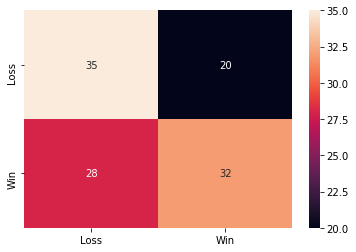

Accuracy for win/loss prediction: 0.5826086956521739


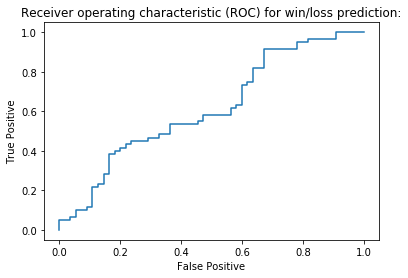

Area under ROC-Curve for win/loss prediction: 0.6151515151515151


In [30]:
print_stat_before_game_start(h_validation)

In [31]:
def print_predicted_run_graph(h_file,game_number):
    X_var=np.array(h_file[str(game_number)+'_features'])
    y_var=np.array(h_file[str(game_number)+'_target'])
    One_Hot_balls=X_var[:,BAL_COL:BAL_COL+121]
    balls=np.argmax(One_Hot_balls,axis=1)
    #First innings
    mask=X_var[:,CS_COL]==0
    f_X_var=X_var[mask]
    f_y_var=y_var[mask]
    f_balls=balls[mask]
    rp=[]
    for i in range(f_X_var.shape[0]):
        ball=f_balls[i]
        run=X_var[i,RUN_COL]
        rp.append((run/(ball+1e-08))*120)
    f_X_var=scaler.transform(f_X_var)
    var_output=model.predict(f_X_var)[:,0]
    plt.plot(f_balls,f_y_var[:,0],label="Actual total run.")
    plt.plot(f_balls,var_output,label="Total run predicted by our algorithm.")
    plt.plot(f_balls,rp,label="Total run predicted by only using runrate.")
    plt.title('Total run predicted by run rate vs toal run predicted by using our algorithm on first innings.')
    plt.xlabel('Balls')
    plt.ylabel('Runs')
    plt.ylim([0, 350])
    plt.legend()
    plt.show()

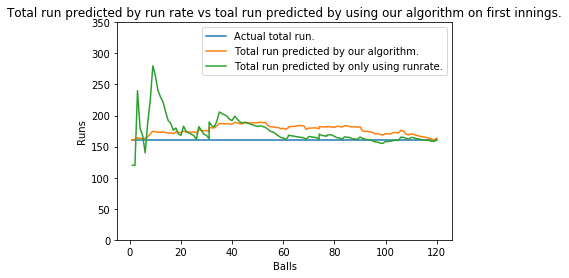

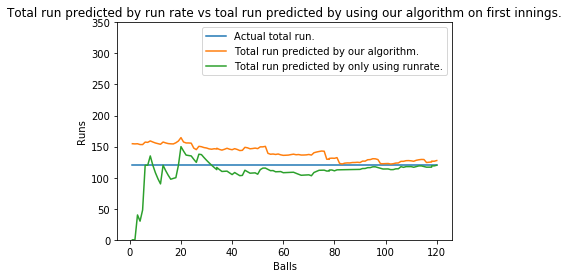

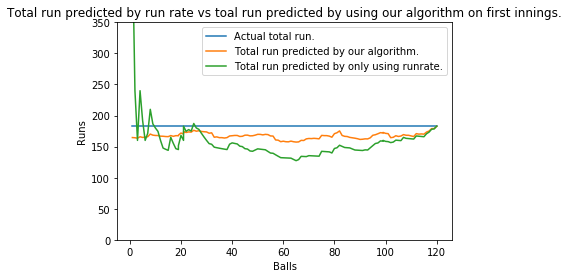

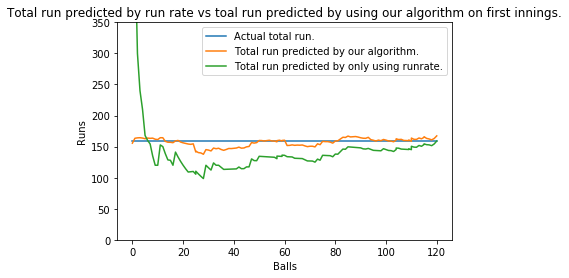

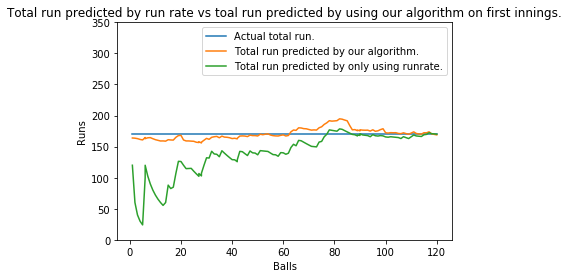

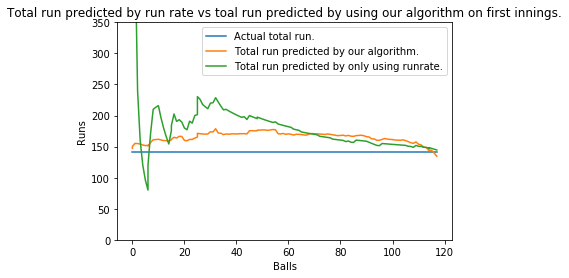

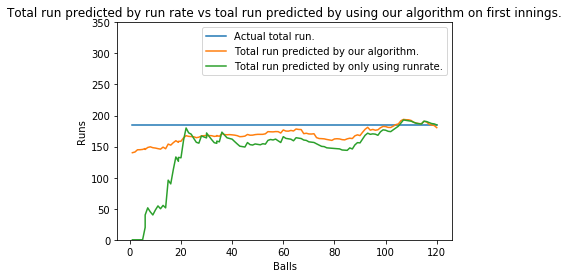

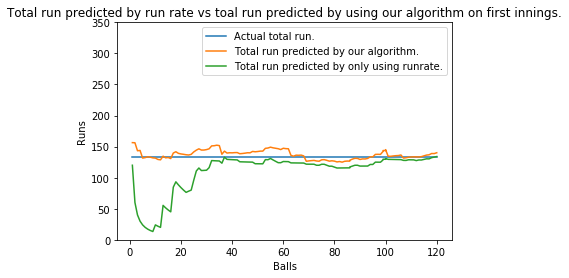

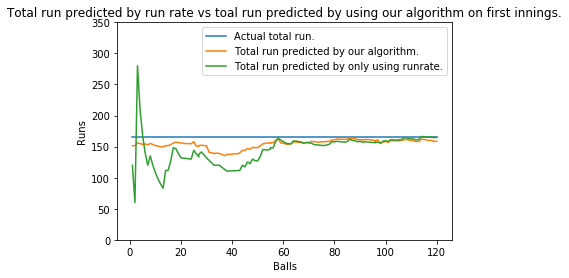

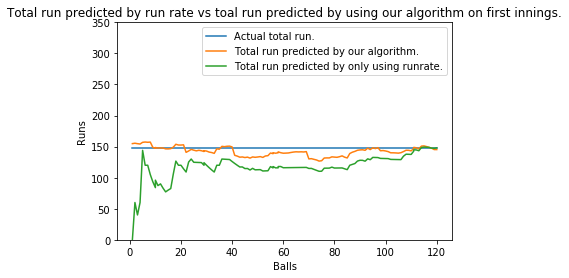

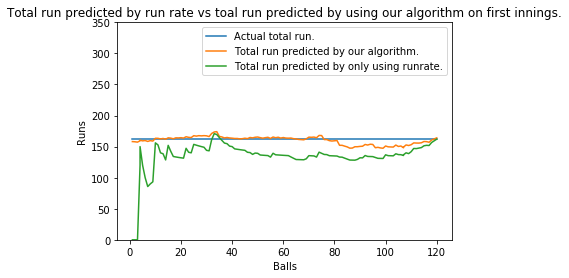

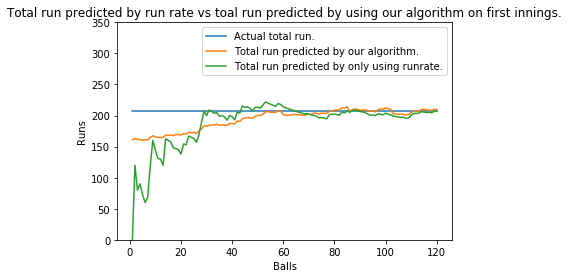

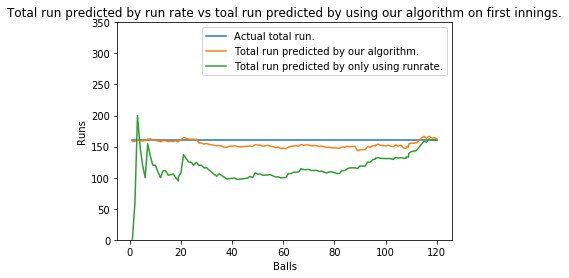

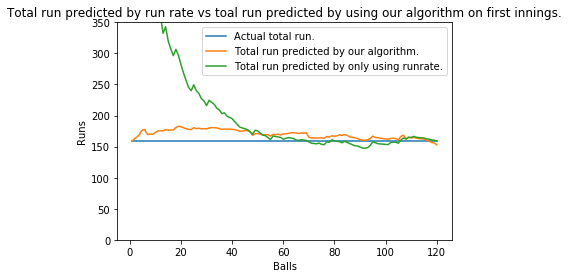

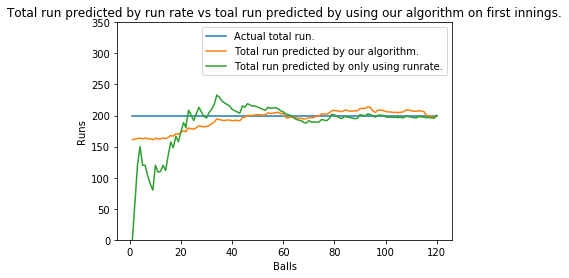

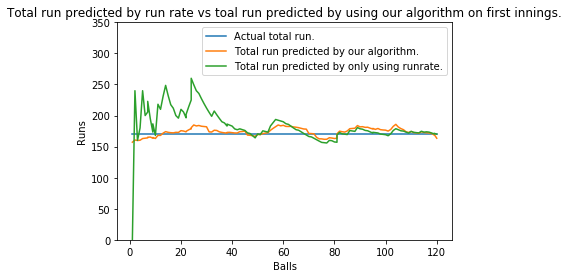

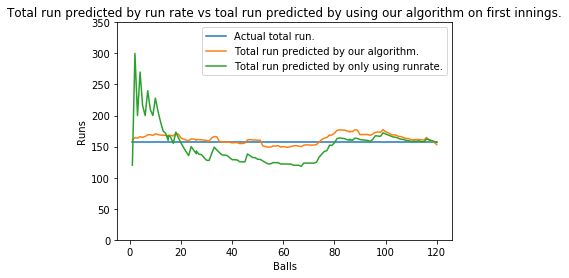

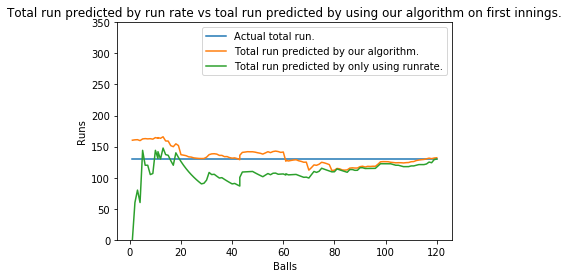

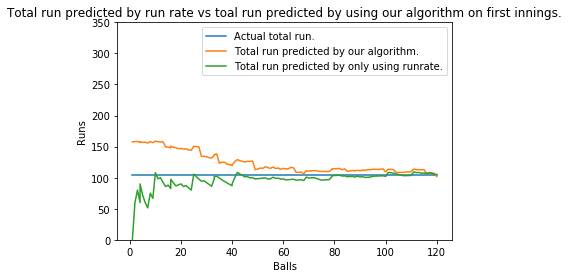

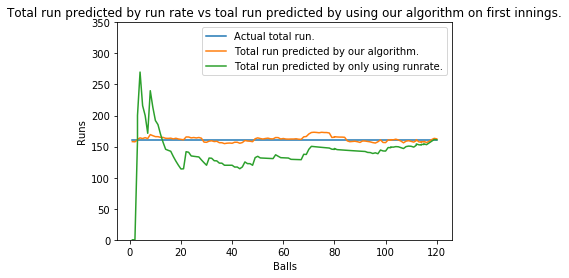

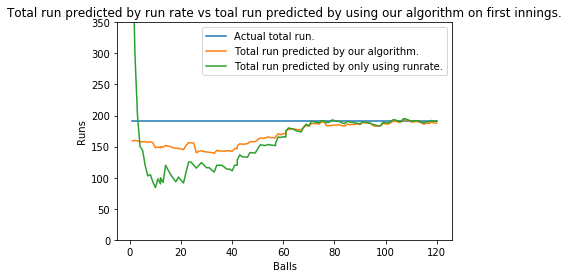

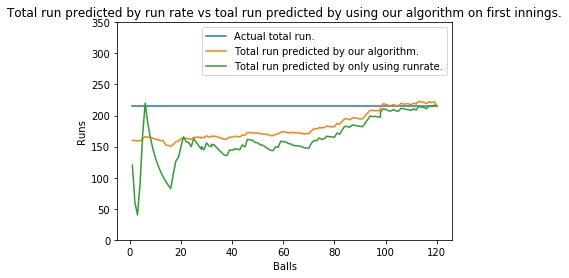

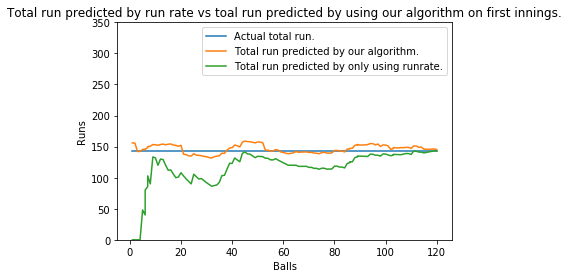

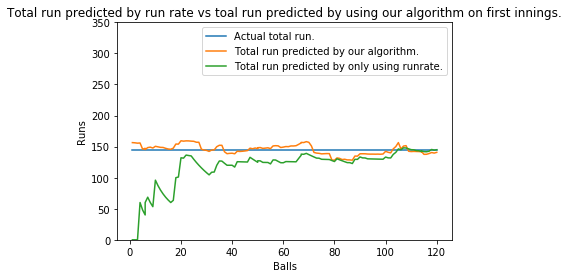

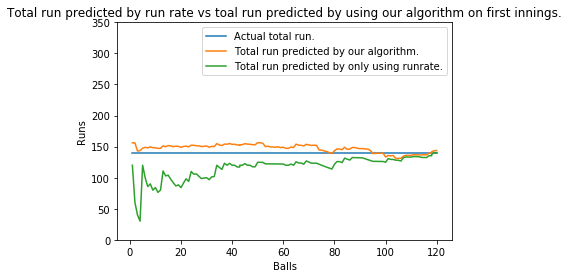

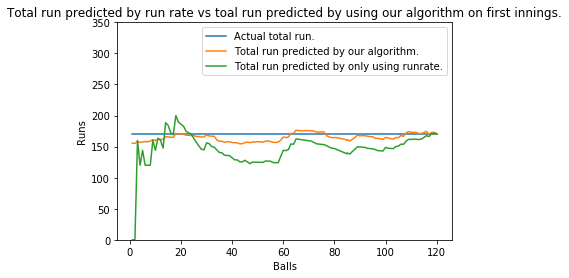

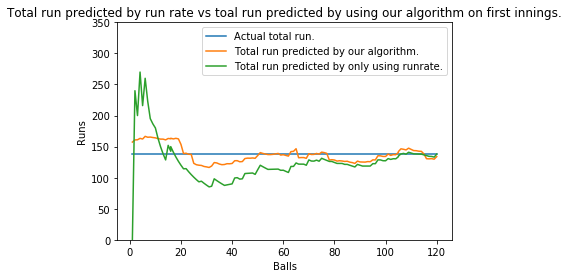

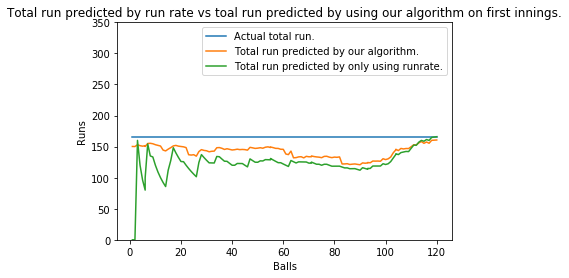

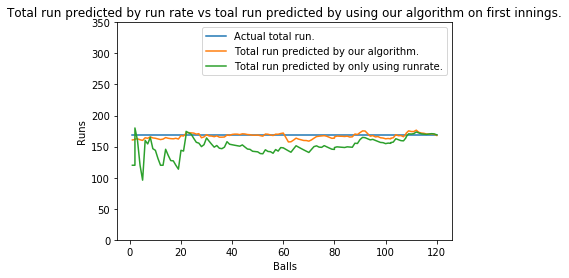

In [32]:
for i in range(1,30):
    print_predicted_run_graph(h_train,i)

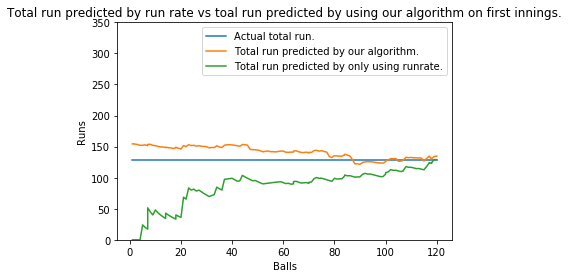

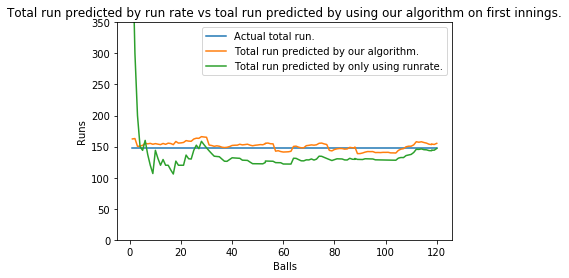

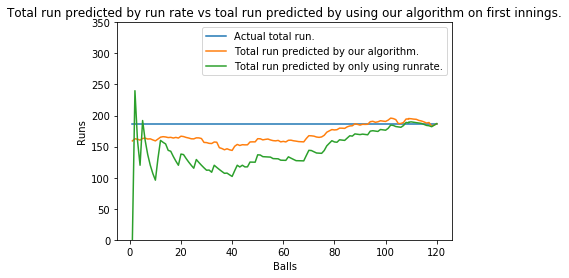

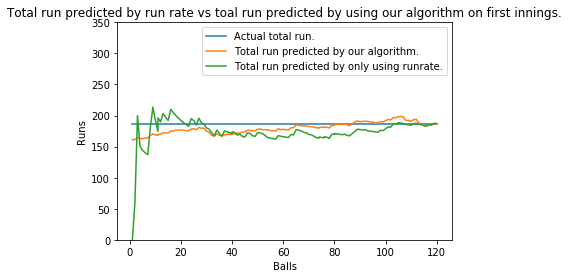

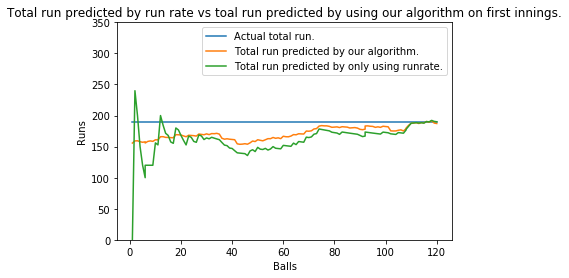

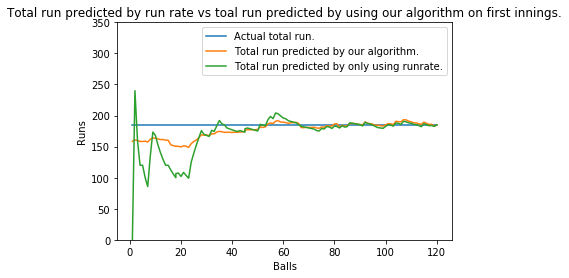

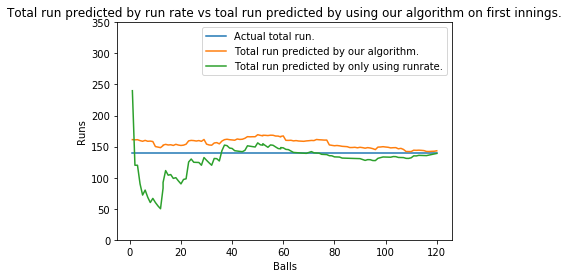

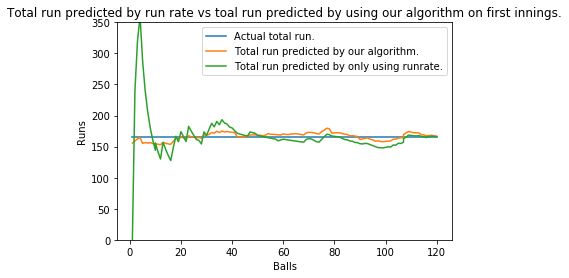

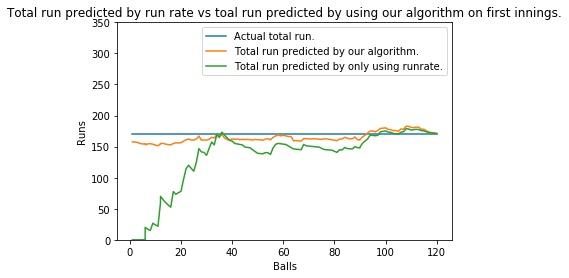

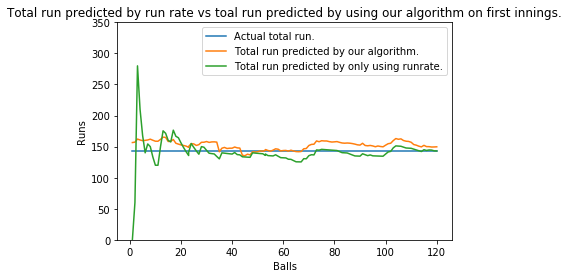

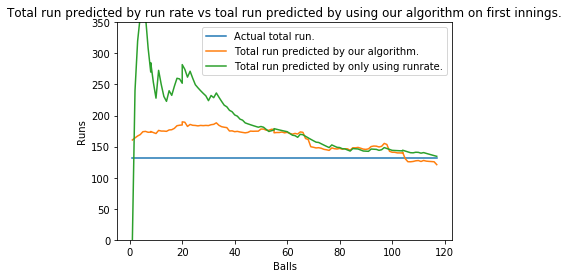

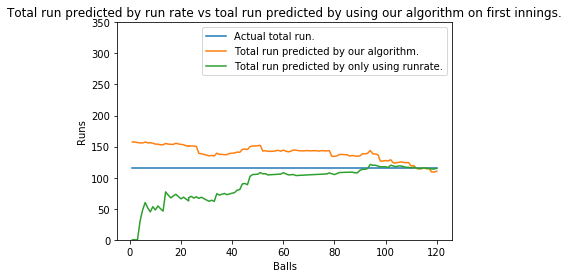

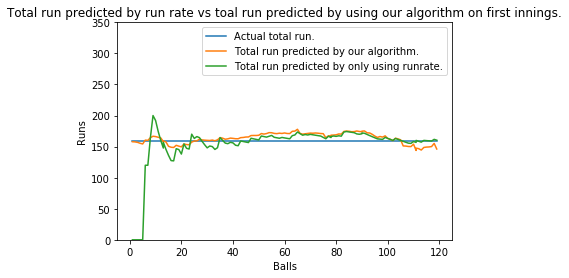

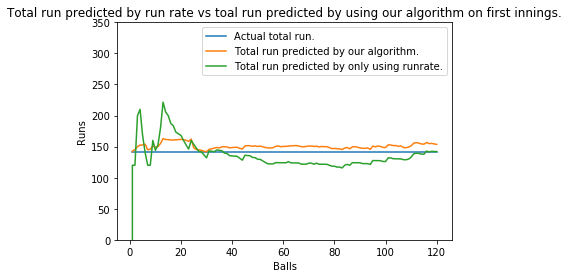

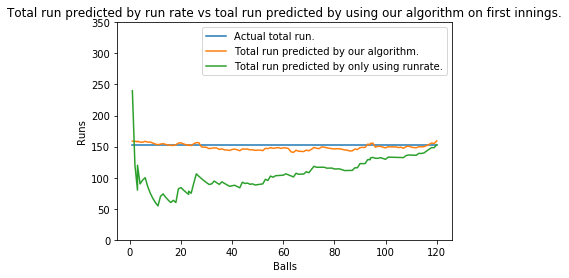

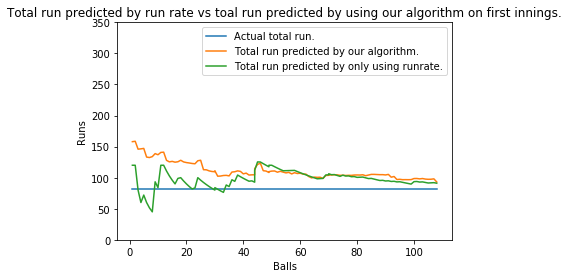

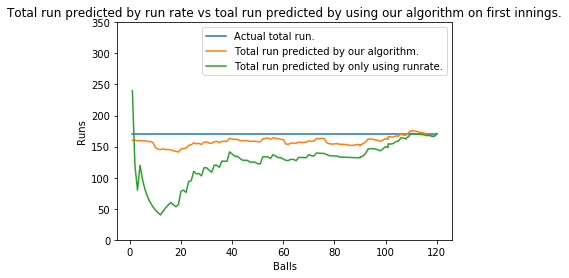

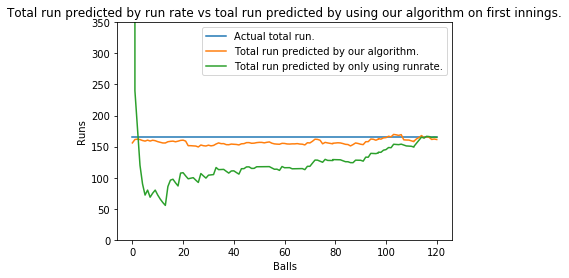

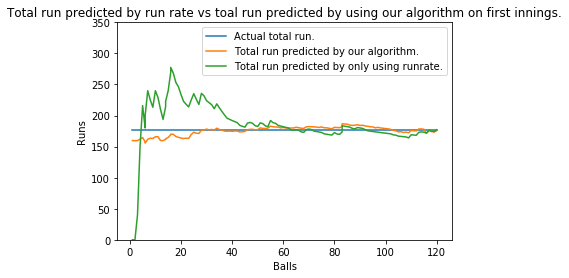

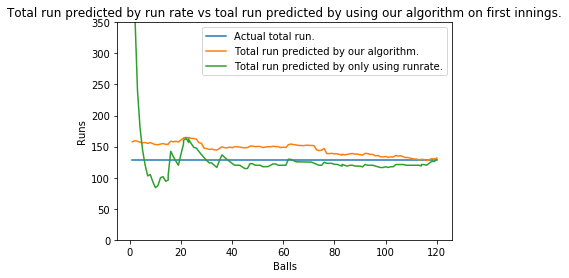

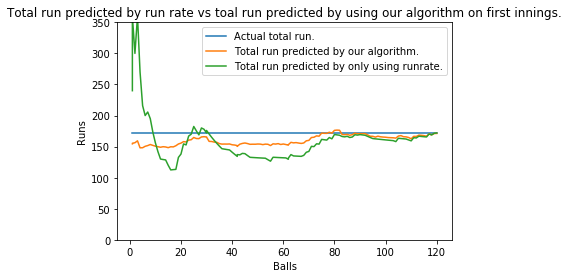

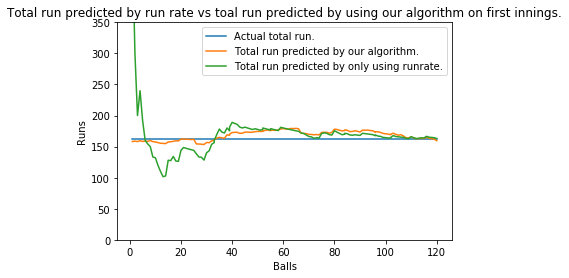

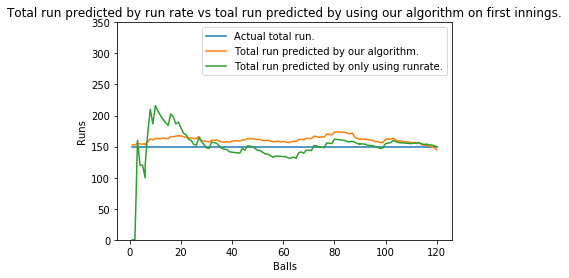

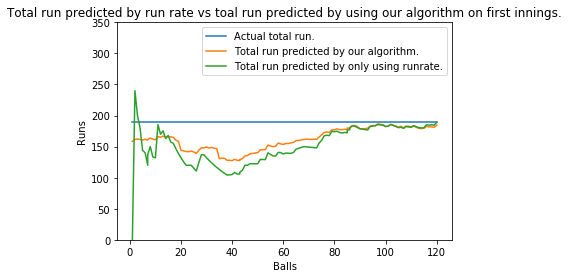

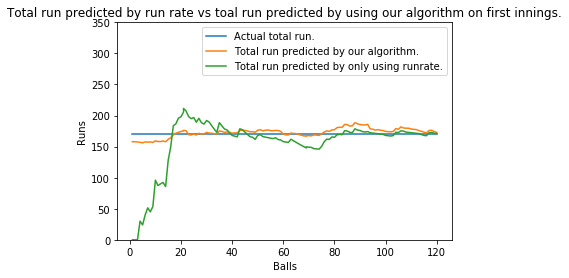

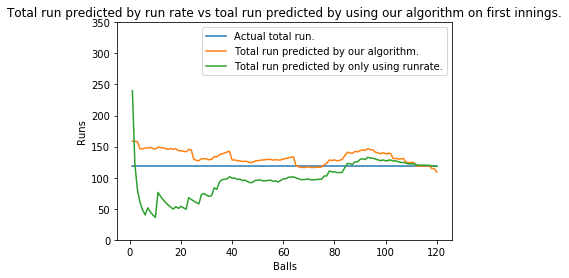

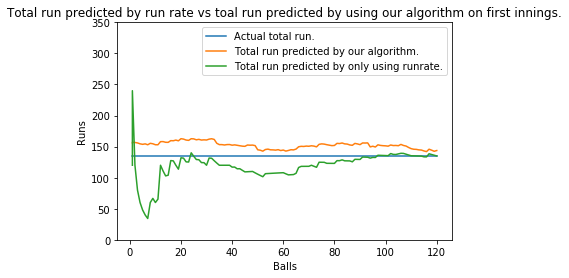

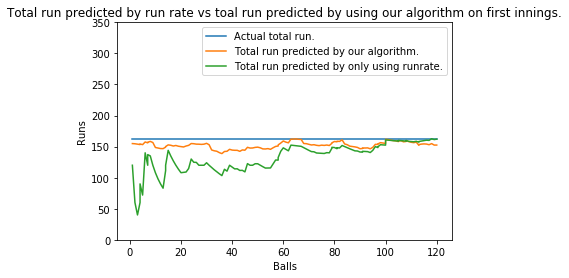

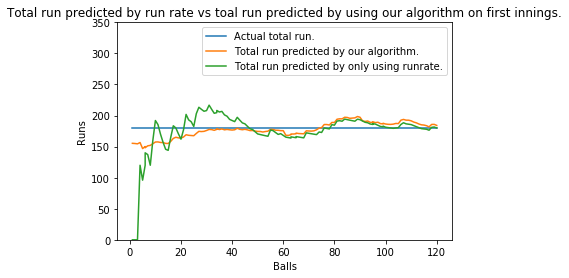

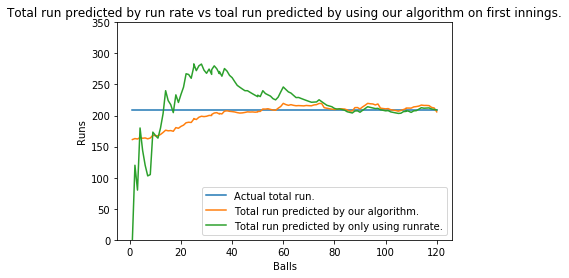

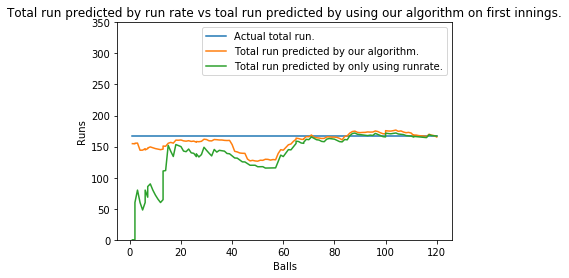

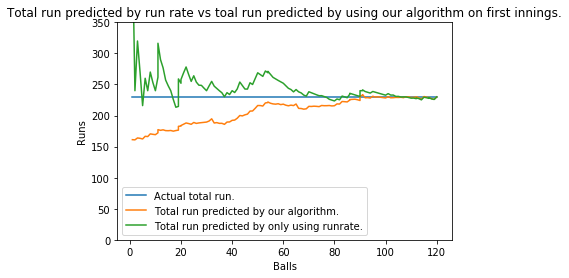

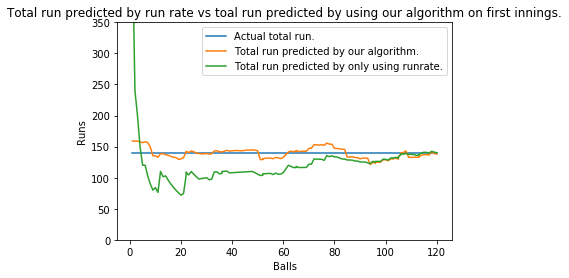

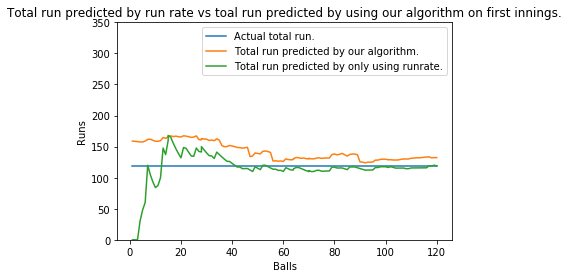

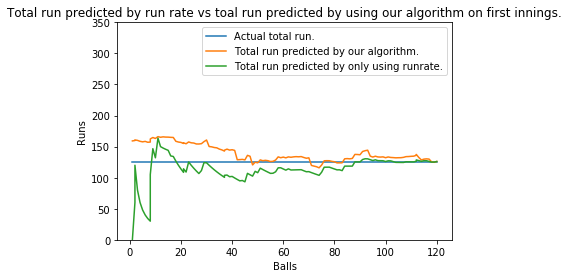

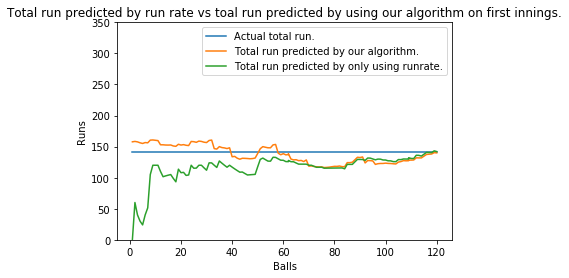

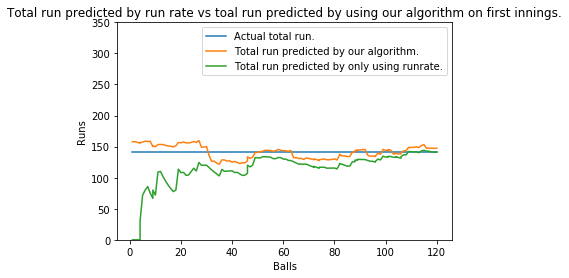

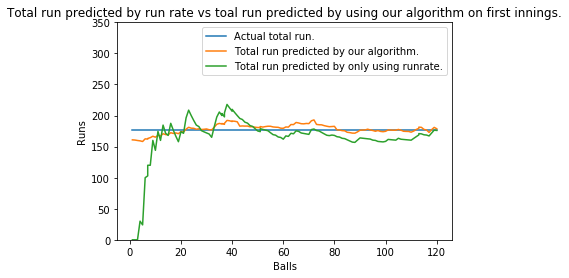

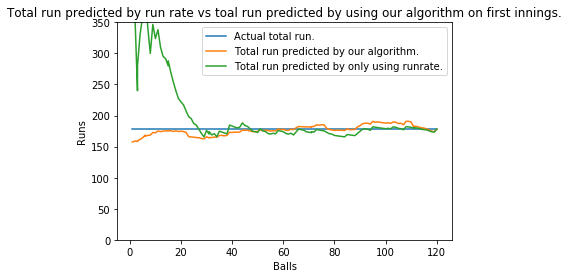

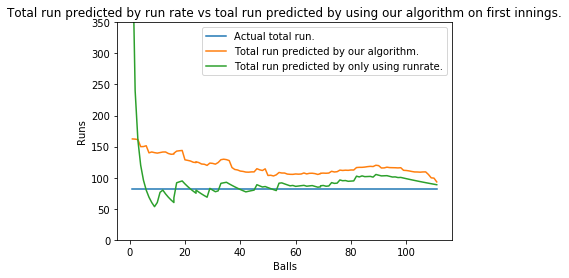

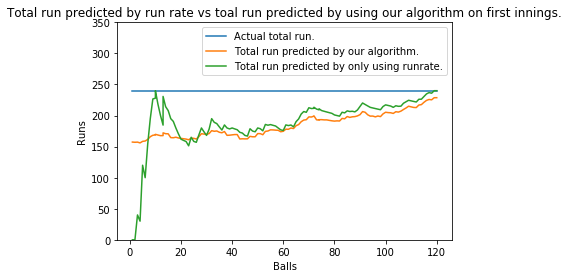

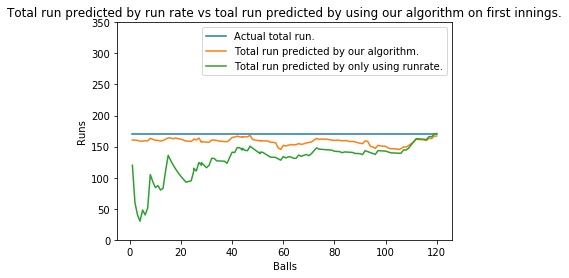

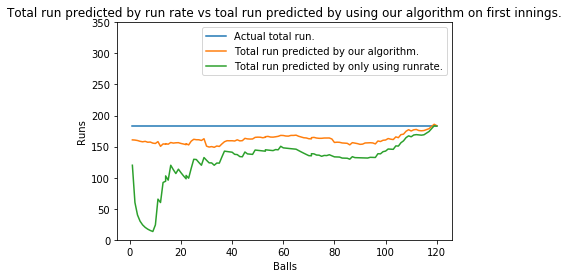

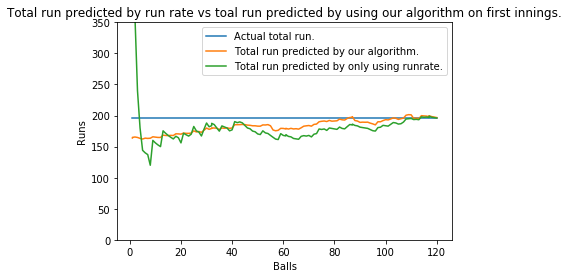

In [33]:
for i in range(1,45):
    print_predicted_run_graph(h_test,i)

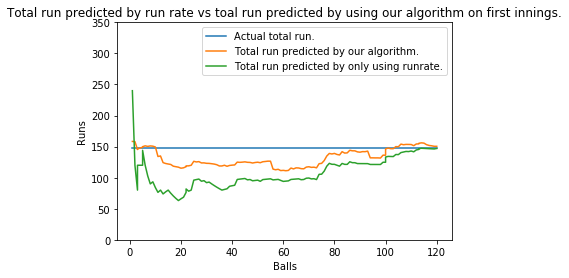

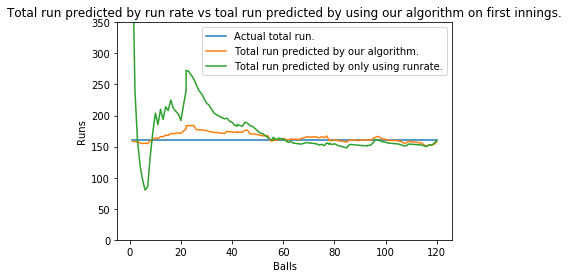

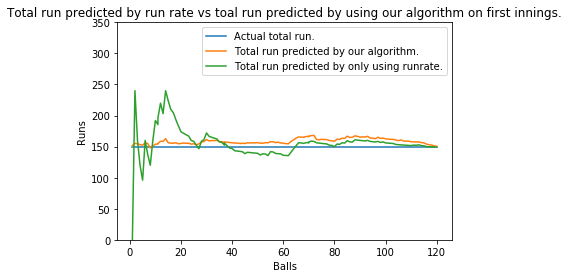

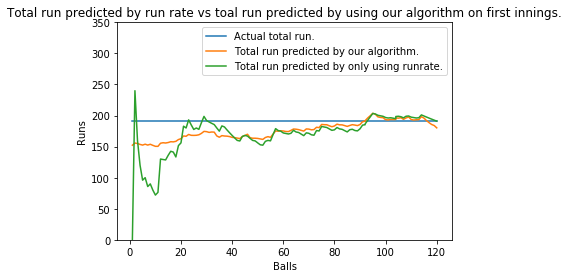

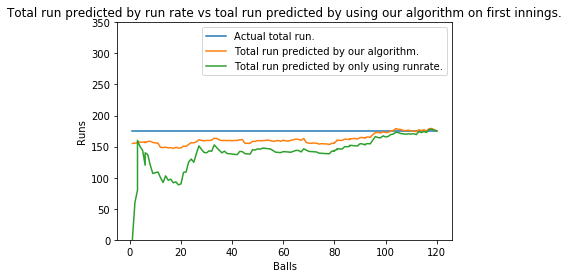

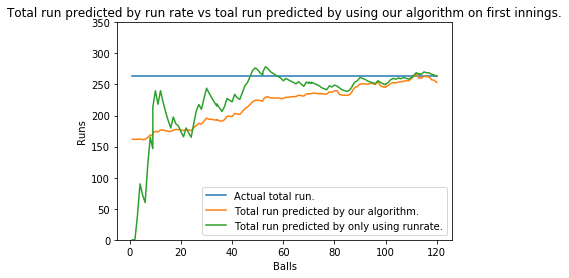

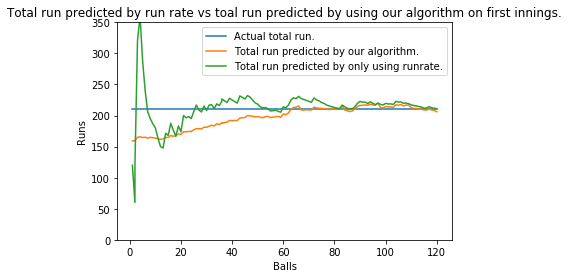

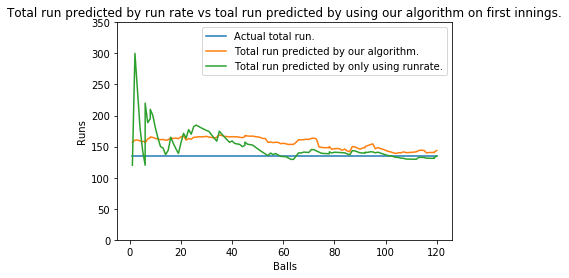

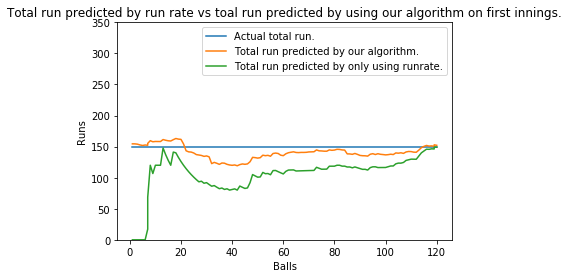

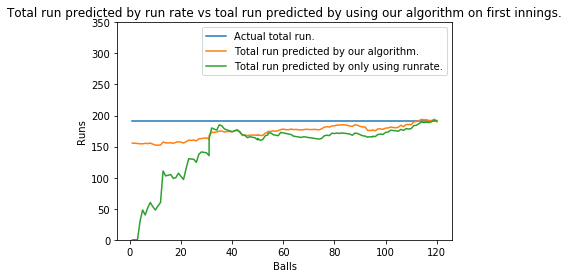

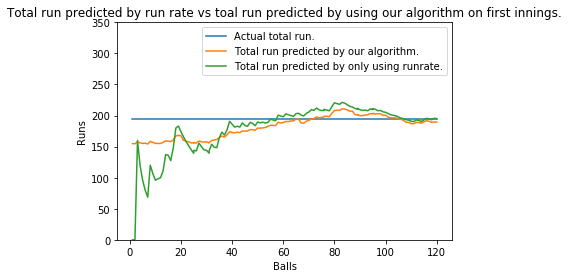

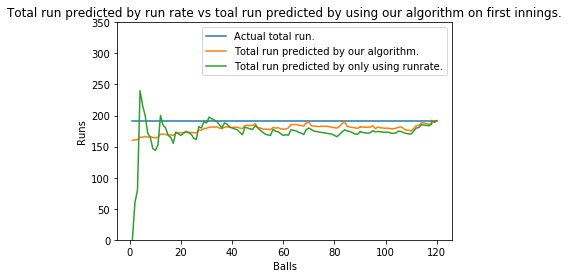

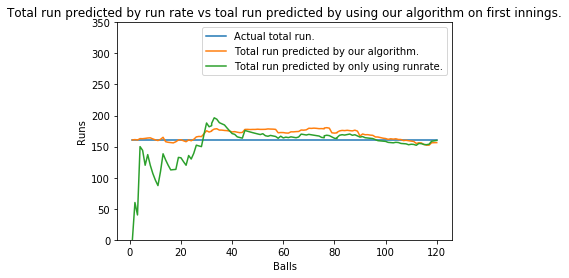

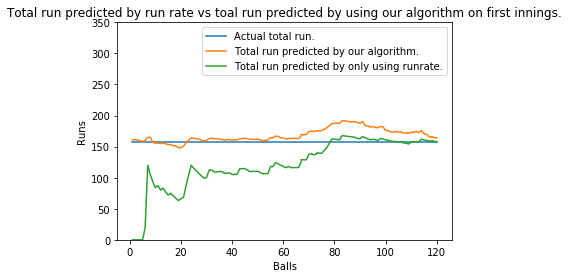

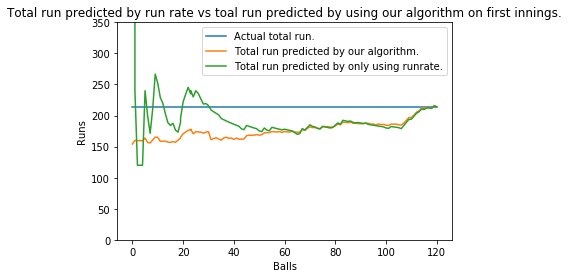

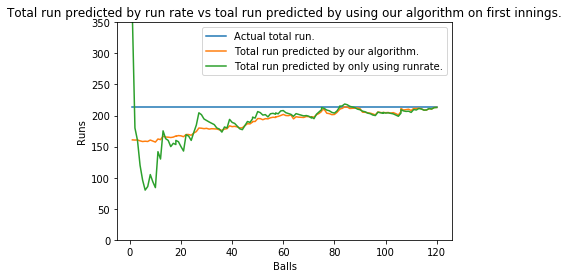

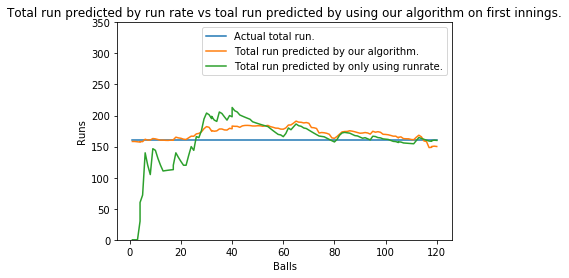

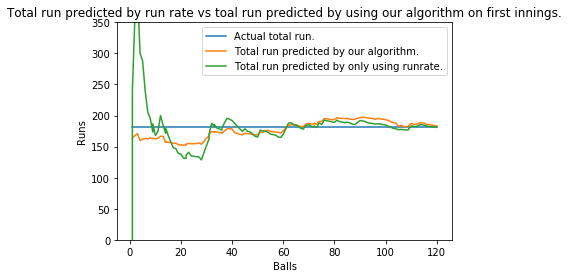

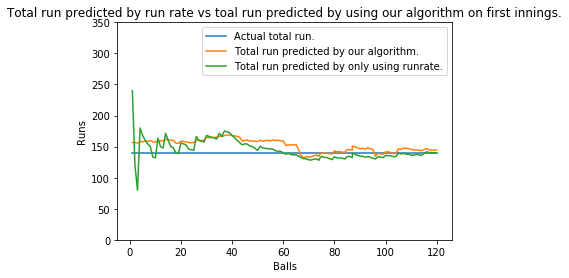

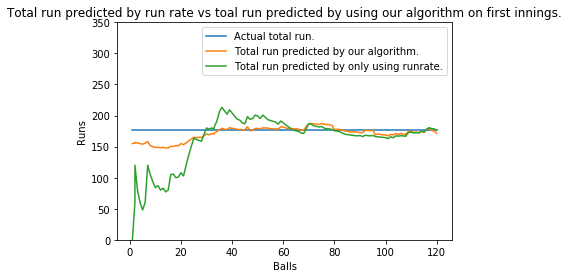

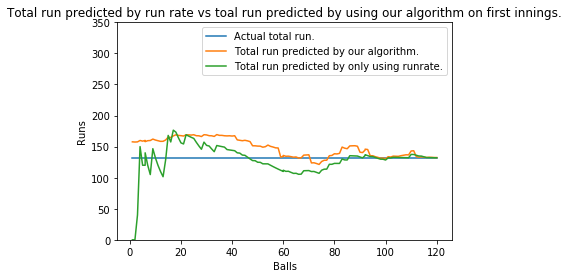

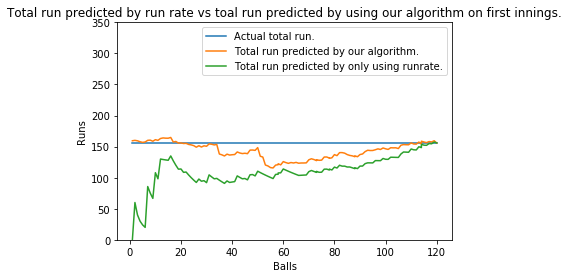

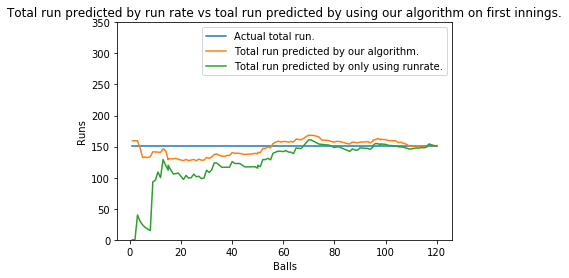

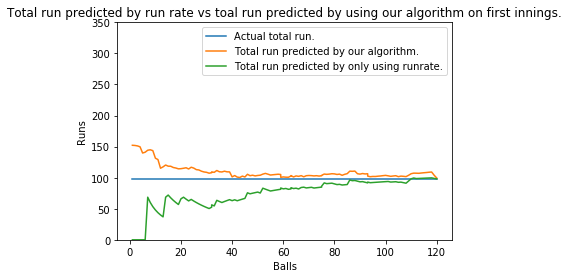

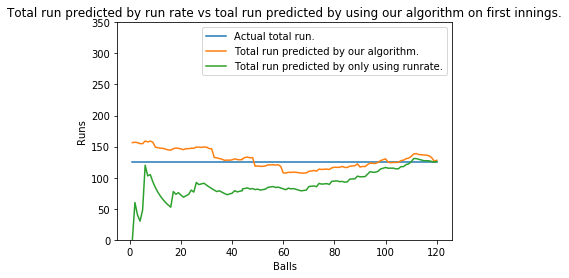

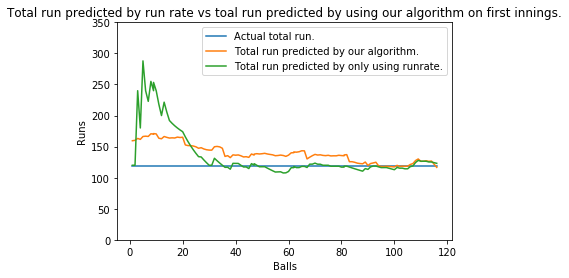

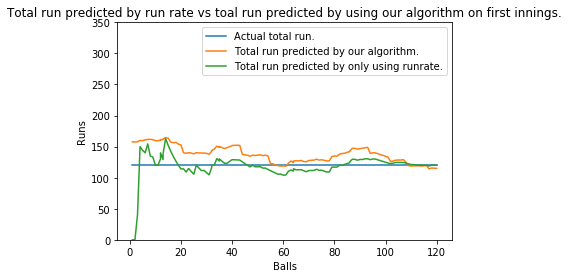

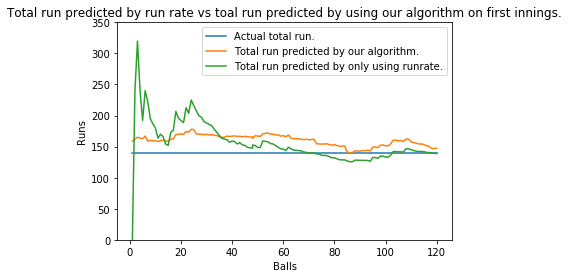

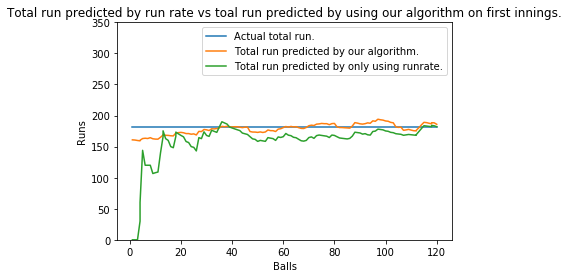

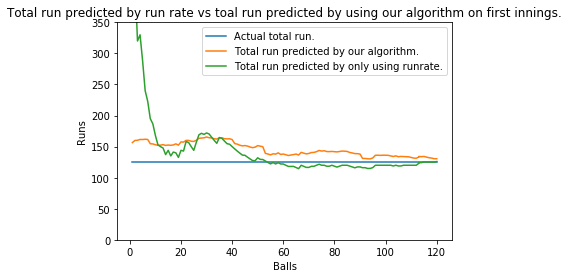

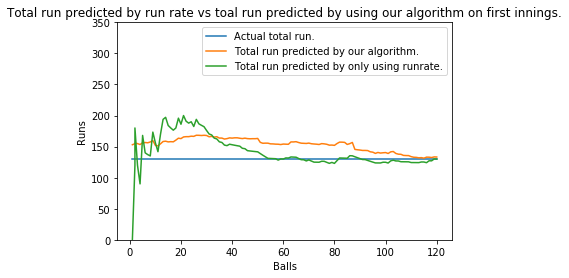

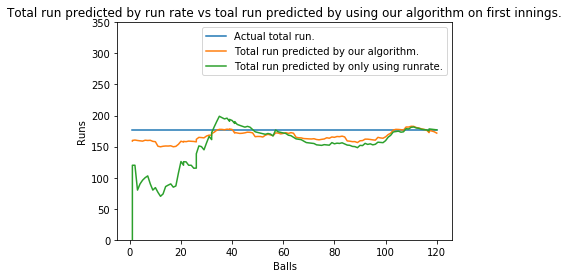

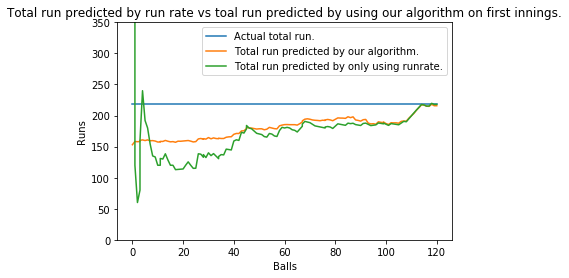

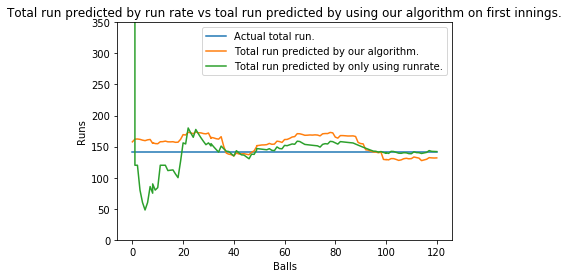

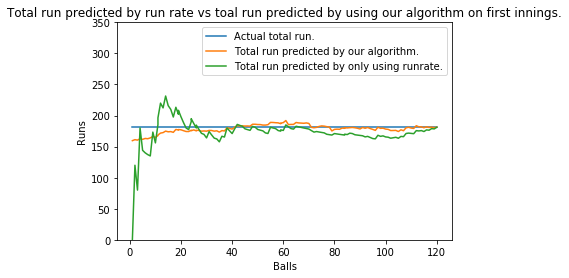

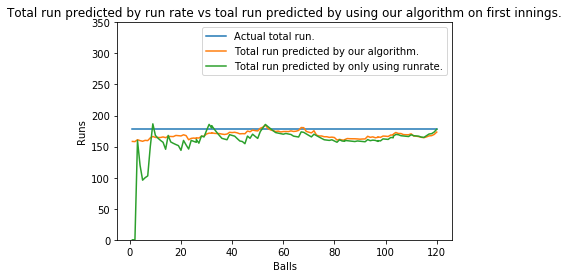

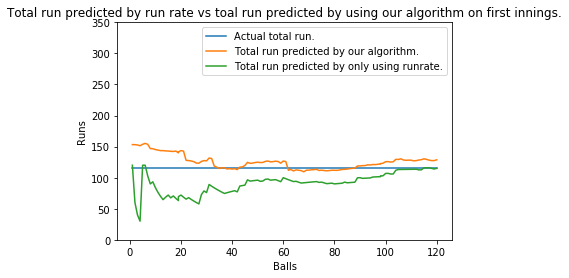

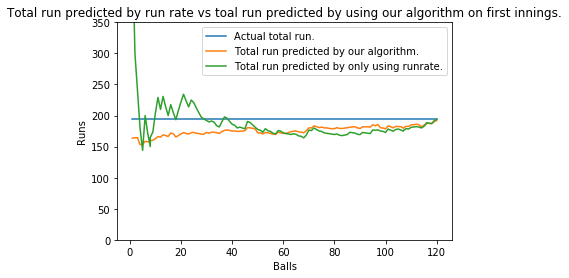

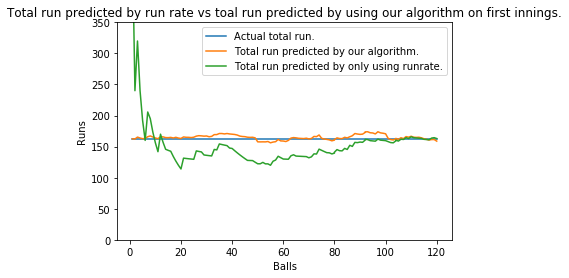

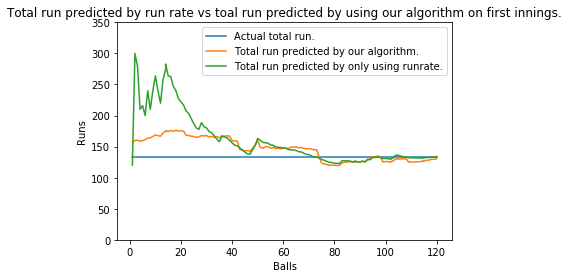

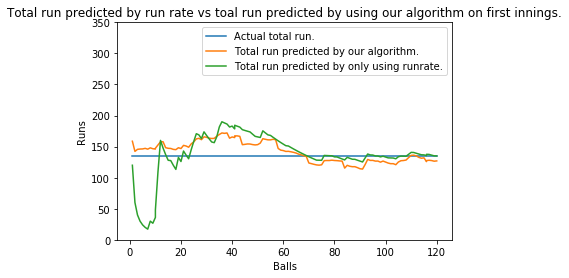

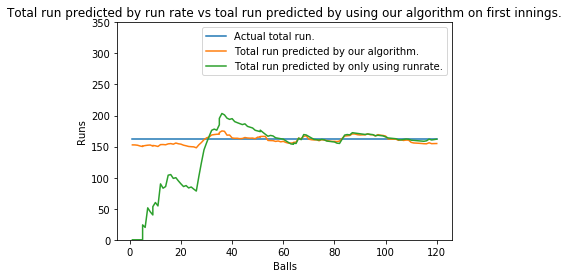

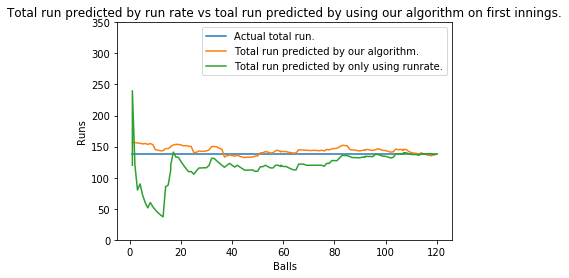

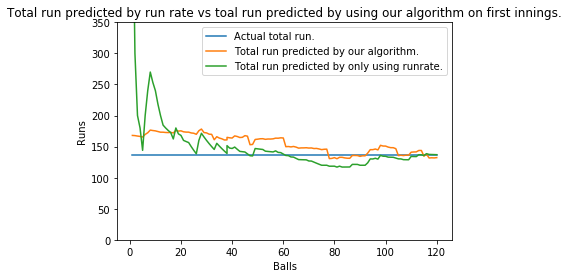

In [34]:
for i in range(1,45):
    print_predicted_run_graph(h_validation,i)

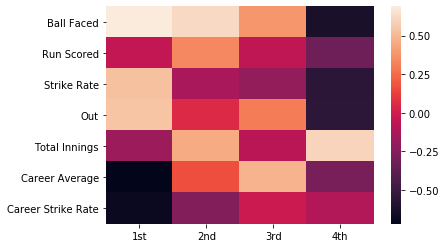

In [35]:
batting_conv1d_weights=np.array(trainable_model.get_layer('first_batting_conv1d').get_weights()[0]).reshape((7,4))
batting_conv1d_weights=pd.DataFrame(batting_conv1d_weights,index=['Ball Faced','Run Scored','Strike Rate','Out','Total Innings','Career Average','Career Strike Rate'],columns=['1st','2nd','3rd','4th'])
se.heatmap(batting_conv1d_weights)

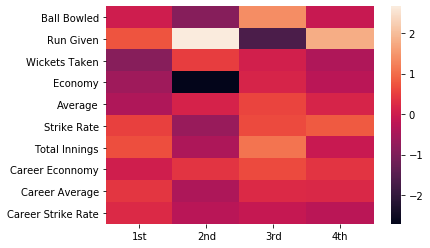

In [36]:
bowling_conv1d_weights=np.array(trainable_model.get_layer('first_bowling_conv1d').get_weights()[0]).reshape((10,4))
bowling_conv1d_weights=pd.DataFrame(bowling_conv1d_weights,index=['Ball Bowled','Run Given','Wickets Taken','Economy','Average','Strike Rate','Total Innings','Career Econnomy','Career Average','Career Strike Rate'],columns=['1st','2nd','3rd','4th'])
se.heatmap(bowling_conv1d_weights)

# Vanilla Neural Networks

### Traning on complete Tuple

In [76]:
reg_model = Sequential([
    Dense(8, input_shape=(318,),kernel_regularizer=regularizers.l2(0.03)),
    Activation('relu'),
    Dense(4,kernel_regularizer=regularizers.l2(0.03)),
    Activation('relu'),
    Dense(1),
    Activation('relu'),
])
reg_model.compile(optimizer=Adam(0.007),loss='mean_squared_error')

In [77]:
reg_model.fit(X_train,y_train[:,0],epochs=15,batch_size=64,validation_data=(X_validation,y_validation[:,0]))

Train on 127785 samples, validate on 27522 samples
Epoch 1/15
127785/127785 [==============================] - 6s 50us/step - loss: 4512.5856 - val_loss: 672.3560
Epoch 2/15
127785/127785 [==============================] - 5s 39us/step - loss: 511.0067 - val_loss: 511.7079
Epoch 3/15
127785/127785 [==============================] - 5s 39us/step - loss: 444.0528 - val_loss: 481.7214
Epoch 4/15
127785/127785 [==============================] - 5s 43us/step - loss: 415.1607 - val_loss: 462.3020
Epoch 5/15
127785/127785 [==============================] - 5s 40us/step - loss: 394.9101 - val_loss: 448.3787
Epoch 6/15
127785/127785 [==============================] - 5s 40us/step - loss: 379.5311 - val_loss: 440.0167
Epoch 7/15
127785/127785 [==============================] - 5s 40us/step - loss: 366.5835 - val_loss: 440.2157
Epoch 8/15
127785/127785 [==============================] - 5s 40us/step - loss: 354.5579 - val_loss: 424.6299
Epoch 9/15
127785/127785 [==============================] - 

In [78]:
cls_model = Sequential([
    Dense(8, input_shape=(318,),kernel_regularizer=regularizers.l2(0.03)),
    Activation('relu'),
    Dense(4,kernel_regularizer=regularizers.l2(0.03)),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid'),
])
cls_model.compile(optimizer=Adam(0.007),loss='binary_crossentropy')

In [79]:
cls_model.fit(X_train,y_train[:,1],epochs=15,batch_size=64,validation_data=(X_validation,y_validation[:,1]))

Train on 127785 samples, validate on 27522 samples
Epoch 1/15
127785/127785 [==============================] - 7s 57us/step - loss: 0.6460 - val_loss: 0.6514
Epoch 2/15
127785/127785 [==============================] - 6s 49us/step - loss: 0.6215 - val_loss: 0.6340
Epoch 3/15
127785/127785 [==============================] - 6s 45us/step - loss: 0.6139 - val_loss: 0.6415
Epoch 4/15
127785/127785 [==============================] - 6s 43us/step - loss: 0.6108 - val_loss: 0.6500
Epoch 5/15
127785/127785 [==============================] - 6s 43us/step - loss: 0.6075 - val_loss: 0.6773
Epoch 6/15
127785/127785 [==============================] - 6s 44us/step - loss: 0.6055 - val_loss: 0.6267
Epoch 7/15
127785/127785 [==============================] - 6s 44us/step - loss: 0.6043 - val_loss: 0.6521
Epoch 8/15
127785/127785 [==============================] - 6s 44us/step - loss: 0.6047 - val_loss: 0.6548
Epoch 9/15
127785/127785 [==============================] - 7s 56us/step - loss: 0.6032 - val

### Traning only on game state

In [89]:
gs_reg_model = Sequential([
    Dense(16, input_shape=(GS,)),
    Activation('relu'),
    Dense(8),
    Activation('relu'),
    Dense(1),
    Activation('relu'),
])
gs_reg_model.compile(optimizer=Adam(0.007),loss='mean_squared_error')

In [90]:
gs_reg_model.fit(X_train[:,0:GS],y_train[:,0],epochs=15,batch_size=64,validation_data=(X_validation[:,0:GS],y_validation[:,0]))

Train on 127785 samples, validate on 27522 samples
Epoch 1/15
127785/127785 [==============================] - 6s 50us/step - loss: 1443.7961 - val_loss: 409.4045
Epoch 2/15
127785/127785 [==============================] - 5s 38us/step - loss: 367.0893 - val_loss: 411.1576
Epoch 3/15
127785/127785 [==============================] - 5s 42us/step - loss: 364.2680 - val_loss: 397.8964
Epoch 4/15
127785/127785 [==============================] - 5s 39us/step - loss: 361.8462 - val_loss: 411.3682
Epoch 5/15
127785/127785 [==============================] - 6s 45us/step - loss: 360.7270 - val_loss: 391.0009
Epoch 6/15
127785/127785 [==============================] - 5s 42us/step - loss: 359.3484 - val_loss: 389.7325
Epoch 7/15
127785/127785 [==============================] - 6s 44us/step - loss: 358.0851 - val_loss: 386.5632
Epoch 8/15
127785/127785 [==============================] - 5s 40us/step - loss: 357.8236 - val_loss: 395.0679
Epoch 9/15
127785/127785 [==============================] - 

In [91]:
gs_cls_model = Sequential([
    Dense(16, input_shape=(GS,)),
    Activation('relu'),
    Dense(8),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid'),
])
gs_cls_model.compile(optimizer=Adam(0.007),loss='binary_crossentropy')

In [92]:
gs_cls_model.fit(X_train[:,0:GS],y_train[:,1],epochs=15,batch_size=64,validation_data=(X_validation[:,0:GS],y_validation[:,1]))

Train on 127785 samples, validate on 27522 samples
Epoch 1/15
127785/127785 [==============================] - 10s 77us/step - loss: 0.5725 - val_loss: 0.5549
Epoch 2/15
127785/127785 [==============================] - 6s 45us/step - loss: 0.5498 - val_loss: 0.5572
Epoch 3/15
127785/127785 [==============================] - 6s 44us/step - loss: 0.5430 - val_loss: 0.5528
Epoch 4/15
127785/127785 [==============================] - 6s 49us/step - loss: 0.5389 - val_loss: 0.5577
Epoch 5/15
127785/127785 [==============================] - 6s 43us/step - loss: 0.5358 - val_loss: 0.5860
Epoch 6/15
127785/127785 [==============================] - 6s 46us/step - loss: 0.5341 - val_loss: 0.5578
Epoch 7/15
127785/127785 [==============================] - 6s 45us/step - loss: 0.5318 - val_loss: 0.5787
Epoch 8/15
127785/127785 [==============================] - 6s 44us/step - loss: 0.5302 - val_loss: 0.5701
Epoch 9/15
127785/127785 [==============================] - 6s 46us/step - loss: 0.5287 - va

# Multi-tasking training only on game state

In [95]:
Inputs=Input(shape=(GS,))
x=Dense(32,activation='relu')(Inputs)
x=Dense(16,activation='relu')(x)
x=Dense(8,activation='relu')(x)
x=Dense(4,activation='relu')(x)
x=Dense(2,activation=None)(x)
#Process Output
runs=Lambda(lambda x:x[:,0])(x)
runs=Activation('relu')(runs)
runs=Reshape((1,))(runs)
probs=Lambda(lambda x:x[:,1])(x)
probs=Activation('sigmoid')(probs)
probs=Reshape((1,))(probs)
Output=Concatenate(axis=1)([runs,probs])
#Define Model
gs_model=Model(inputs=Inputs,outputs=Output)

In [96]:
gs_model.compile(optimizer=Adam(0.0001),loss=custome_loss(600),metrics=[mse_loss,bc_loss])

In [97]:
gs_model.fit(X_train[:,0:GS],y_train,epochs=50,batch_size=64,validation_data=(X_validation[:,0:GS],y_validation))

Train on 127785 samples, validate on 27522 samples
Epoch 1/50
127785/127785 [==============================] - 8s 66us/step - loss: 14972.9459 - mse_loss: 14554.7855 - bc_loss: 0.6969 - val_loss: 3364.7363 - val_mse_loss: 2948.7441 - val_bc_loss: 0.6933
Epoch 2/50
127785/127785 [==============================] - 6s 50us/step - loss: 2378.0161 - mse_loss: 1961.8034 - bc_loss: 0.6937 - val_loss: 2083.9107 - val_mse_loss: 1668.5782 - val_bc_loss: 0.6922
Epoch 3/50
127785/127785 [==============================] - 9s 74us/step - loss: 1390.6017 - mse_loss: 976.0611 - bc_loss: 0.6909 - val_loss: 1253.9946 - val_mse_loss: 840.9757 - val_bc_loss: 0.6884
Epoch 4/50
127785/127785 [==============================] - 10s 75us/step - loss: 990.9115 - mse_loss: 579.0795 - bc_loss: 0.6864 - val_loss: 1014.9260 - val_mse_loss: 605.7350 - val_bc_loss: 0.6820
Epoch 5/50
127785/127785 [==============================] - 9s 71us/step - loss: 884.5659 - mse_loss: 477.2006 - bc_loss: 0.6789 - val_loss: 926.20

KeyboardInterrupt: 